***Importamos las librerías necesarias :***

In [1]:
import os
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
from pathlib import Path
import torch.optim as optim
import torch.nn.functional as F
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report

***Guardamos las trayectorias con sus respectivas clases en "complete_df" :***

In [2]:
csv_files = [
    "./Trayectorias/Tipos_de_barcos/longitud_28/Cargo_modificado_compressed_28_v2_COMPLETO.csv",
    "./Trayectorias/Tipos_de_barcos/longitud_28/Container_modificado_compressed_28_v2_COMPLETO.csv",
    "./Trayectorias/Tipos_de_barcos/longitud_28/Tanker_modificado_compressed_28_v2_COMPLETO.csv"
]

complete_df = pd.DataFrame()

for file in csv_files:
    df = pd.read_csv(file)
    df['Bearing'] = df['Bearing'].round(4)
    grouped = df.groupby('Trajectory_ID')['Bearing'].apply(lambda x: [i for i in x if pd.notna(i)]).reset_index()
    grouped['Type'] = file.split('/')[-1].split('_')[0]
    complete_df = pd.concat([complete_df, grouped], ignore_index=True)

### COMPROBACIÓN BEARING ###
for tipo in complete_df['Type'].unique():
    first_element = complete_df[complete_df['Type'] == tipo].iloc[0]
    print(f"Type: {tipo}, Trajectory_ID: {first_element['Trajectory_ID']}, Bearing: {first_element['Bearing']}")

print()

### COMPROBACIÓN NÚMERO DE TRAYECTORIAS ###
print("Número total de trayectorias:", len(complete_df))
class_counts = complete_df['Type'].value_counts()
print(class_counts)

Type: Cargo, Trajectory_ID: 6, Bearing: [85.9813, 83.4948, 81.4367, 79.4248, 78.7669, 82.293, 84.1563, 86.5258, 82.196, 84.2905, 80.7255, 77.7342, 74.3326, 72.3342, 76.6374, 76.1252, 78.2791, 76.2551, 80.5085, 81.2342, 87.8038, 83.9483, 82.2021, 74.2397, 81.9476, 80.4048, 81.639]
Type: Container, Trajectory_ID: 24, Bearing: [79.0256, 83.3049, 86.553, 83.0474, 75.7304, 81.6789, 85.1362, 79.984, 78.463, 80.5605, 80.3212, 77.8201, 77.1404, 76.1251, 76.0628, 81.2343, 82.9812, 78.2018, 81.3787, 80.3007, 78.2253, 78.6548, 80.5155, 78.9224, 80.4505, 74.8486, 78.2525]
Type: Tanker, Trajectory_ID: 4, Bearing: [73.149, 84.7242, 80.3463, 75.5419, 80.2578, 83.564, 80.4332, 82.3601, 85.0705, 81.4655, 81.1754, 84.0992, 77.2338, 79.5903, 84.4041, 86.991, 79.4484, 77.106, 82.8404, 77.2214, 80.1858, 81.5052, 76.7469, 73.4563, 77.4019, 76.6975, 84.6507]

Número total de trayectorias: 955
Type
Cargo        648
Tanker       211
Container     96
Name: count, dtype: int64


***Dividimos "complete_df" en entrenamiento y test :***

In [3]:
complete_df = complete_df.sample(frac=1, random_state=42).reset_index(drop=True)

test_size = 0.2
train_df_list = []
test_df_list = []

classes = complete_df['Type'].unique()

for class_name in classes:
    class_subset = complete_df[complete_df['Type'] == class_name]
    
    test_count = int(len(class_subset) * test_size)
    
    test_df_list.append(class_subset.iloc[:test_count])
    train_df_list.append(class_subset.iloc[test_count:])

train_df = pd.concat(train_df_list).reset_index(drop=True)
test_df = pd.concat(test_df_list).reset_index(drop=True)

train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

#### COMPROBACIÓN ####
print(f"Nº de trayectorias en train: {len(train_df)}")
print(train_df['Type'].value_counts())
print()
print(f"Nº de trayectorias en test: {len(test_df)}")
print(test_df['Type'].value_counts())
print()
print("Ejm. conjunto train:")
print(train_df.head(5))
print()
print("Ejm. conjunto test:")
print(test_df.head(5))

Nº de trayectorias en train: 765
Type
Cargo        519
Tanker       169
Container     77
Name: count, dtype: int64

Nº de trayectorias en test: 190
Type
Cargo        129
Tanker        42
Container     19
Name: count, dtype: int64

Ejm. conjunto train:
   Trajectory_ID                                            Bearing    Type
0           1049  [64.0778, 63.9002, 63.2022, 75.3271, 74.916, 7...   Cargo
1            878  [41.6313, 67.0505, 49.6143, 64.8078, 53.1357, ...   Cargo
2            209  [14.1834, 338.1289, 21.4326, 110.865, 228.0552...  Tanker
3           1558  [59.8969, 62.7657, 67.7545, 58.733, 53.69, 39....   Cargo
4           1048  [351.5859, 312.7834, 311.723, 230.7689, 55.436...   Cargo

Ejm. conjunto test:
   Trajectory_ID                                            Bearing    Type
0           1155  [75.7382, 53.4513, 54.6615, 31.239, 28.5613, 4...  Tanker
1            974  [65.3321, 65.9314, 59.2055, 71.8668, 39.6723, ...  Tanker
2            553  [76.4694, 72.0284, 72.938

***Pre-procesado de los datos :***

In [4]:
#Convertimos Bearing a un array de numpy
X_train = np.array(train_df['Bearing'].tolist())
X_test = np.array(test_df['Bearing'].tolist())

#Normalizamos los valores de Bearing
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Añadimos una dimensión extra para que tenga la forma (n, 1)
X_train = np.expand_dims(X_train, axis = -1)
X_test = np.expand_dims(X_test, axis = -1)

#Codificamos las etiquetas de Type
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['Type'])
y_test = label_encoder.transform(test_df['Type'])

#Conversión a tensores
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

X_train = torch.tensor(X_train, dtype=torch.float32).permute(0, 2, 1).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).permute(0, 2, 1).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

print("X_train:", X_train.shape, X_train.device)
print("y_train:", y_train.shape, y_train.device)
print("X_test:", X_test.shape, X_test.device)
print("y_test:", y_test.shape, y_test.device)

Device: cuda
X_train: torch.Size([765, 1, 27]) cuda:0
y_train: torch.Size([765]) cuda:0
X_test: torch.Size([190, 1, 27]) cuda:0
y_test: torch.Size([190]) cuda:0


# ***CNN1D :***

In [5]:
class CNN1D(nn.Module):
    def __init__(self, num_classes):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * (X_train.shape[2] // 4), 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

***Configuración del modelo :***

In [6]:
k_folds = 5
batch_size = 32
num_epochs = 100
num_classes = 3

***Entrenamiento del modelo :***

In [7]:
train_dataset = TensorDataset(X_train, y_train)
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

fold_train_acc = []
fold_train_loss = []
fold_val_acc = []
fold_val_loss = []

best_val_acc = 0
best_epoch_train_acc = []
best_epoch_val_acc = []
best_epoch_train_loss = []
best_epoch_val_loss = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):

    epoch_train_acc = []
    epoch_val_acc = []
    epoch_train_loss = []
    epoch_val_loss = []

    print(f"\n📂 Fold {fold+1}/{k_folds}")

    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    model = CNN1D(num_classes=num_classes).to(device)

    #Pesos inversamente proporcionales a la frecuencia de las clases
    label_counts = Counter(y_train.cpu().numpy())
    total_count = sum(label_counts.values())
    weights = [total_count / (num_classes * label_counts[label]) for label in range(len(label_counts))]

    criterion = nn.CrossEntropyLoss(weight=torch.tensor(weights).to(device))
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        for inputs, labels in tqdm(train_loader, desc=f"Fold {fold+1} | Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train

        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct_val / total_val

        epoch_train_acc.append(train_acc)
        epoch_val_acc.append(val_acc)
        epoch_train_loss.append(avg_train_loss)
        epoch_val_loss.append(avg_val_loss)

        print(f"Fold {fold+1} - Epoch {epoch+1} ✅ | Train Acc: {train_acc:.2f}% - Train Loss: {avg_train_loss:.4f} | Val Acc: {val_acc:.2f}% - Val Loss: {avg_val_loss:.4f}")

    fold_train_acc.append(train_acc)
    fold_val_acc.append(val_acc)
    fold_train_loss.append(avg_train_loss)
    fold_val_loss.append(avg_val_loss)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        save_path = "./Modelos/v2/representacion_1/longitud_28"
        os.makedirs(save_path, exist_ok=True)
        torch.save(model.state_dict(), f"{save_path}/CNN1D_fold_{fold+1}.pth")
        best_epoch_train_acc = epoch_train_acc.copy()
        best_epoch_val_acc = epoch_val_acc.copy()
        best_epoch_train_loss = epoch_train_loss.copy()
        best_epoch_val_loss = epoch_val_loss.copy()

print("\nRESULTADOS:")
print(f"-> Mean Train Accuracy: {np.mean(fold_train_acc):.4f}%")
print(f"-> Mean Train Loss: {np.mean(fold_train_loss):.4f}")
print(f"-> Mean Validation Accuracy: {np.mean(fold_val_acc):.4f}%")
print(f"-> Mean Validation Loss: {np.mean(fold_val_loss):.4f}")


📂 Fold 1/5


Fold 1 | Epoch 1/100: 100%|██████████| 20/20 [00:03<00:00,  5.89it/s]


Fold 1 - Epoch 1 ✅ | Train Acc: 34.31% - Train Loss: 1.0948 | Val Acc: 35.29% - Val Loss: 1.0881


Fold 1 | Epoch 2/100: 100%|██████████| 20/20 [00:00<00:00, 410.08it/s]


Fold 1 - Epoch 2 ✅ | Train Acc: 45.75% - Train Loss: 1.0740 | Val Acc: 22.22% - Val Loss: 1.0646


Fold 1 | Epoch 3/100: 100%|██████████| 20/20 [00:00<00:00, 370.43it/s]


Fold 1 - Epoch 3 ✅ | Train Acc: 29.25% - Train Loss: 1.0427 | Val Acc: 22.22% - Val Loss: 1.0495


Fold 1 | Epoch 4/100: 100%|██████████| 20/20 [00:00<00:00, 293.77it/s]


Fold 1 - Epoch 4 ✅ | Train Acc: 35.13% - Train Loss: 1.0181 | Val Acc: 22.22% - Val Loss: 1.0759


Fold 1 | Epoch 5/100: 100%|██████████| 20/20 [00:00<00:00, 393.54it/s]


Fold 1 - Epoch 5 ✅ | Train Acc: 32.19% - Train Loss: 1.0100 | Val Acc: 24.18% - Val Loss: 1.0405


Fold 1 | Epoch 6/100: 100%|██████████| 20/20 [00:00<00:00, 339.32it/s]


Fold 1 - Epoch 6 ✅ | Train Acc: 27.29% - Train Loss: 1.0123 | Val Acc: 30.72% - Val Loss: 1.0671


Fold 1 | Epoch 7/100: 100%|██████████| 20/20 [00:00<00:00, 258.77it/s]


Fold 1 - Epoch 7 ✅ | Train Acc: 45.75% - Train Loss: 0.9806 | Val Acc: 54.90% - Val Loss: 0.9798


Fold 1 | Epoch 8/100: 100%|██████████| 20/20 [00:00<00:00, 303.26it/s]


Fold 1 - Epoch 8 ✅ | Train Acc: 39.05% - Train Loss: 0.9772 | Val Acc: 40.52% - Val Loss: 1.0027


Fold 1 | Epoch 9/100: 100%|██████████| 20/20 [00:00<00:00, 316.20it/s]


Fold 1 - Epoch 9 ✅ | Train Acc: 41.34% - Train Loss: 0.9775 | Val Acc: 31.37% - Val Loss: 1.0618


Fold 1 | Epoch 10/100: 100%|██████████| 20/20 [00:00<00:00, 333.79it/s]


Fold 1 - Epoch 10 ✅ | Train Acc: 41.83% - Train Loss: 0.9774 | Val Acc: 29.41% - Val Loss: 1.1082


Fold 1 | Epoch 11/100: 100%|██████████| 20/20 [00:00<00:00, 334.28it/s]


Fold 1 - Epoch 11 ✅ | Train Acc: 42.65% - Train Loss: 0.9566 | Val Acc: 62.09% - Val Loss: 0.9827


Fold 1 | Epoch 12/100: 100%|██████████| 20/20 [00:00<00:00, 258.82it/s]


Fold 1 - Epoch 12 ✅ | Train Acc: 43.14% - Train Loss: 0.9481 | Val Acc: 44.44% - Val Loss: 1.0546


Fold 1 | Epoch 13/100: 100%|██████████| 20/20 [00:00<00:00, 350.44it/s]


Fold 1 - Epoch 13 ✅ | Train Acc: 50.16% - Train Loss: 0.9446 | Val Acc: 38.56% - Val Loss: 1.1150


Fold 1 | Epoch 14/100: 100%|██████████| 20/20 [00:00<00:00, 337.45it/s]


Fold 1 - Epoch 14 ✅ | Train Acc: 48.86% - Train Loss: 0.9385 | Val Acc: 56.21% - Val Loss: 1.0553


Fold 1 | Epoch 15/100: 100%|██████████| 20/20 [00:00<00:00, 349.20it/s]


Fold 1 - Epoch 15 ✅ | Train Acc: 48.86% - Train Loss: 0.9323 | Val Acc: 41.18% - Val Loss: 1.0779


Fold 1 | Epoch 16/100: 100%|██████████| 20/20 [00:00<00:00, 319.19it/s]


Fold 1 - Epoch 16 ✅ | Train Acc: 43.30% - Train Loss: 0.9574 | Val Acc: 37.91% - Val Loss: 1.1113


Fold 1 | Epoch 17/100: 100%|██████████| 20/20 [00:00<00:00, 288.34it/s]


Fold 1 - Epoch 17 ✅ | Train Acc: 42.97% - Train Loss: 0.9299 | Val Acc: 41.18% - Val Loss: 1.0847


Fold 1 | Epoch 18/100: 100%|██████████| 20/20 [00:00<00:00, 329.95it/s]


Fold 1 - Epoch 18 ✅ | Train Acc: 46.57% - Train Loss: 0.9531 | Val Acc: 46.41% - Val Loss: 1.1112


Fold 1 | Epoch 19/100: 100%|██████████| 20/20 [00:00<00:00, 410.38it/s]


Fold 1 - Epoch 19 ✅ | Train Acc: 48.04% - Train Loss: 0.9226 | Val Acc: 39.22% - Val Loss: 1.1230


Fold 1 | Epoch 20/100: 100%|██████████| 20/20 [00:00<00:00, 371.32it/s]


Fold 1 - Epoch 20 ✅ | Train Acc: 41.34% - Train Loss: 0.9153 | Val Acc: 39.87% - Val Loss: 1.1028


Fold 1 | Epoch 21/100: 100%|██████████| 20/20 [00:00<00:00, 357.22it/s]


Fold 1 - Epoch 21 ✅ | Train Acc: 47.39% - Train Loss: 0.9342 | Val Acc: 54.25% - Val Loss: 1.0954


Fold 1 | Epoch 22/100: 100%|██████████| 20/20 [00:00<00:00, 273.70it/s]


Fold 1 - Epoch 22 ✅ | Train Acc: 43.95% - Train Loss: 0.9266 | Val Acc: 39.87% - Val Loss: 1.1693


Fold 1 | Epoch 23/100: 100%|██████████| 20/20 [00:00<00:00, 329.14it/s]


Fold 1 - Epoch 23 ✅ | Train Acc: 46.57% - Train Loss: 0.9130 | Val Acc: 39.22% - Val Loss: 1.1785


Fold 1 | Epoch 24/100: 100%|██████████| 20/20 [00:00<00:00, 261.45it/s]


Fold 1 - Epoch 24 ✅ | Train Acc: 47.55% - Train Loss: 0.9413 | Val Acc: 53.59% - Val Loss: 1.1824


Fold 1 | Epoch 25/100: 100%|██████████| 20/20 [00:00<00:00, 411.30it/s]


Fold 1 - Epoch 25 ✅ | Train Acc: 48.86% - Train Loss: 0.9321 | Val Acc: 39.22% - Val Loss: 1.0984


Fold 1 | Epoch 26/100: 100%|██████████| 20/20 [00:00<00:00, 409.84it/s]


Fold 1 - Epoch 26 ✅ | Train Acc: 49.51% - Train Loss: 0.9120 | Val Acc: 40.52% - Val Loss: 1.1960


Fold 1 | Epoch 27/100: 100%|██████████| 20/20 [00:00<00:00, 410.30it/s]


Fold 1 - Epoch 27 ✅ | Train Acc: 45.10% - Train Loss: 0.9225 | Val Acc: 52.94% - Val Loss: 1.1936


Fold 1 | Epoch 28/100: 100%|██████████| 20/20 [00:00<00:00, 411.60it/s]


Fold 1 - Epoch 28 ✅ | Train Acc: 52.61% - Train Loss: 0.9490 | Val Acc: 39.22% - Val Loss: 1.2304


Fold 1 | Epoch 29/100: 100%|██████████| 20/20 [00:00<00:00, 358.60it/s]


Fold 1 - Epoch 29 ✅ | Train Acc: 46.41% - Train Loss: 0.9205 | Val Acc: 39.87% - Val Loss: 1.2070


Fold 1 | Epoch 30/100: 100%|██████████| 20/20 [00:00<00:00, 359.85it/s]


Fold 1 - Epoch 30 ✅ | Train Acc: 45.59% - Train Loss: 0.9320 | Val Acc: 39.87% - Val Loss: 1.2726


Fold 1 | Epoch 31/100: 100%|██████████| 20/20 [00:00<00:00, 357.96it/s]


Fold 1 - Epoch 31 ✅ | Train Acc: 43.79% - Train Loss: 0.9335 | Val Acc: 39.87% - Val Loss: 1.2811


Fold 1 | Epoch 32/100: 100%|██████████| 20/20 [00:00<00:00, 320.35it/s]


Fold 1 - Epoch 32 ✅ | Train Acc: 51.14% - Train Loss: 0.8991 | Val Acc: 43.14% - Val Loss: 1.2448


Fold 1 | Epoch 33/100: 100%|██████████| 20/20 [00:00<00:00, 359.66it/s]


Fold 1 - Epoch 33 ✅ | Train Acc: 51.63% - Train Loss: 0.8950 | Val Acc: 37.91% - Val Loss: 1.3150


Fold 1 | Epoch 34/100: 100%|██████████| 20/20 [00:00<00:00, 360.41it/s]


Fold 1 - Epoch 34 ✅ | Train Acc: 47.71% - Train Loss: 0.9023 | Val Acc: 46.41% - Val Loss: 1.2862


Fold 1 | Epoch 35/100: 100%|██████████| 20/20 [00:00<00:00, 319.66it/s]


Fold 1 - Epoch 35 ✅ | Train Acc: 47.71% - Train Loss: 0.8728 | Val Acc: 38.56% - Val Loss: 1.2884


Fold 1 | Epoch 36/100: 100%|██████████| 20/20 [00:00<00:00, 289.28it/s]


Fold 1 - Epoch 36 ✅ | Train Acc: 49.35% - Train Loss: 0.8854 | Val Acc: 39.87% - Val Loss: 1.3570


Fold 1 | Epoch 37/100: 100%|██████████| 20/20 [00:00<00:00, 319.65it/s]


Fold 1 - Epoch 37 ✅ | Train Acc: 47.71% - Train Loss: 0.8891 | Val Acc: 53.59% - Val Loss: 1.3512


Fold 1 | Epoch 38/100: 100%|██████████| 20/20 [00:00<00:00, 361.17it/s]


Fold 1 - Epoch 38 ✅ | Train Acc: 55.07% - Train Loss: 0.8843 | Val Acc: 38.56% - Val Loss: 1.3316


Fold 1 | Epoch 39/100: 100%|██████████| 20/20 [00:00<00:00, 358.92it/s]


Fold 1 - Epoch 39 ✅ | Train Acc: 51.63% - Train Loss: 0.9184 | Val Acc: 47.06% - Val Loss: 1.3351


Fold 1 | Epoch 40/100: 100%|██████████| 20/20 [00:00<00:00, 320.75it/s]


Fold 1 - Epoch 40 ✅ | Train Acc: 45.42% - Train Loss: 0.8876 | Val Acc: 38.56% - Val Loss: 1.4332


Fold 1 | Epoch 41/100: 100%|██████████| 20/20 [00:00<00:00, 320.47it/s]


Fold 1 - Epoch 41 ✅ | Train Acc: 47.22% - Train Loss: 0.8915 | Val Acc: 48.37% - Val Loss: 1.3208


Fold 1 | Epoch 42/100: 100%|██████████| 20/20 [00:00<00:00, 320.61it/s]


Fold 1 - Epoch 42 ✅ | Train Acc: 50.00% - Train Loss: 0.8662 | Val Acc: 48.37% - Val Loss: 1.4235


Fold 1 | Epoch 43/100: 100%|██████████| 20/20 [00:00<00:00, 360.37it/s]


Fold 1 - Epoch 43 ✅ | Train Acc: 50.33% - Train Loss: 0.8657 | Val Acc: 40.52% - Val Loss: 1.4074


Fold 1 | Epoch 44/100: 100%|██████████| 20/20 [00:00<00:00, 319.46it/s]


Fold 1 - Epoch 44 ✅ | Train Acc: 53.76% - Train Loss: 0.8600 | Val Acc: 40.52% - Val Loss: 1.4377


Fold 1 | Epoch 45/100: 100%|██████████| 20/20 [00:00<00:00, 359.70it/s]


Fold 1 - Epoch 45 ✅ | Train Acc: 48.37% - Train Loss: 0.8701 | Val Acc: 41.83% - Val Loss: 1.4916


Fold 1 | Epoch 46/100: 100%|██████████| 20/20 [00:00<00:00, 359.28it/s]


Fold 1 - Epoch 46 ✅ | Train Acc: 50.33% - Train Loss: 0.8824 | Val Acc: 39.22% - Val Loss: 1.4604


Fold 1 | Epoch 47/100: 100%|██████████| 20/20 [00:00<00:00, 320.65it/s]


Fold 1 - Epoch 47 ✅ | Train Acc: 51.63% - Train Loss: 0.8591 | Val Acc: 38.56% - Val Loss: 1.4734


Fold 1 | Epoch 48/100: 100%|██████████| 20/20 [00:00<00:00, 239.14it/s]


Fold 1 - Epoch 48 ✅ | Train Acc: 48.86% - Train Loss: 0.8861 | Val Acc: 43.79% - Val Loss: 1.4655


Fold 1 | Epoch 49/100: 100%|██████████| 20/20 [00:00<00:00, 321.09it/s]


Fold 1 - Epoch 49 ✅ | Train Acc: 45.10% - Train Loss: 0.8863 | Val Acc: 37.91% - Val Loss: 1.4892


Fold 1 | Epoch 50/100: 100%|██████████| 20/20 [00:00<00:00, 287.54it/s]


Fold 1 - Epoch 50 ✅ | Train Acc: 54.25% - Train Loss: 0.8404 | Val Acc: 39.22% - Val Loss: 1.5010


Fold 1 | Epoch 51/100: 100%|██████████| 20/20 [00:00<00:00, 287.99it/s]


Fold 1 - Epoch 51 ✅ | Train Acc: 48.86% - Train Loss: 0.8351 | Val Acc: 43.14% - Val Loss: 1.5643


Fold 1 | Epoch 52/100: 100%|██████████| 20/20 [00:00<00:00, 287.24it/s]


Fold 1 - Epoch 52 ✅ | Train Acc: 53.76% - Train Loss: 0.8446 | Val Acc: 43.14% - Val Loss: 1.4645


Fold 1 | Epoch 53/100: 100%|██████████| 20/20 [00:00<00:00, 372.36it/s]


Fold 1 - Epoch 53 ✅ | Train Acc: 48.04% - Train Loss: 0.8665 | Val Acc: 37.91% - Val Loss: 1.5760


Fold 1 | Epoch 54/100: 100%|██████████| 20/20 [00:00<00:00, 371.10it/s]


Fold 1 - Epoch 54 ✅ | Train Acc: 47.06% - Train Loss: 0.8746 | Val Acc: 38.56% - Val Loss: 1.5494


Fold 1 | Epoch 55/100: 100%|██████████| 20/20 [00:00<00:00, 370.12it/s]


Fold 1 - Epoch 55 ✅ | Train Acc: 46.73% - Train Loss: 0.8550 | Val Acc: 42.48% - Val Loss: 1.6468


Fold 1 | Epoch 56/100: 100%|██████████| 20/20 [00:00<00:00, 373.00it/s]


Fold 1 - Epoch 56 ✅ | Train Acc: 52.12% - Train Loss: 0.8644 | Val Acc: 39.22% - Val Loss: 1.5810


Fold 1 | Epoch 57/100: 100%|██████████| 20/20 [00:00<00:00, 281.61it/s]


Fold 1 - Epoch 57 ✅ | Train Acc: 44.77% - Train Loss: 0.8696 | Val Acc: 39.87% - Val Loss: 1.6622


Fold 1 | Epoch 58/100: 100%|██████████| 20/20 [00:00<00:00, 287.64it/s]


Fold 1 - Epoch 58 ✅ | Train Acc: 49.02% - Train Loss: 0.8396 | Val Acc: 39.22% - Val Loss: 1.5840


Fold 1 | Epoch 59/100: 100%|██████████| 20/20 [00:00<00:00, 288.48it/s]


Fold 1 - Epoch 59 ✅ | Train Acc: 48.69% - Train Loss: 0.8535 | Val Acc: 38.56% - Val Loss: 1.6640


Fold 1 | Epoch 60/100: 100%|██████████| 20/20 [00:00<00:00, 249.25it/s]


Fold 1 - Epoch 60 ✅ | Train Acc: 49.84% - Train Loss: 0.8232 | Val Acc: 44.44% - Val Loss: 1.7243


Fold 1 | Epoch 61/100: 100%|██████████| 20/20 [00:00<00:00, 409.33it/s]


Fold 1 - Epoch 61 ✅ | Train Acc: 53.43% - Train Loss: 0.8449 | Val Acc: 39.87% - Val Loss: 1.6647


Fold 1 | Epoch 62/100: 100%|██████████| 20/20 [00:00<00:00, 287.66it/s]


Fold 1 - Epoch 62 ✅ | Train Acc: 51.47% - Train Loss: 0.8459 | Val Acc: 39.87% - Val Loss: 1.5930


Fold 1 | Epoch 63/100: 100%|██████████| 20/20 [00:00<00:00, 328.43it/s]


Fold 1 - Epoch 63 ✅ | Train Acc: 51.47% - Train Loss: 0.8459 | Val Acc: 43.14% - Val Loss: 1.7599


Fold 1 | Epoch 64/100: 100%|██████████| 20/20 [00:00<00:00, 328.95it/s]


Fold 1 - Epoch 64 ✅ | Train Acc: 52.61% - Train Loss: 0.8453 | Val Acc: 38.56% - Val Loss: 1.7038


Fold 1 | Epoch 65/100: 100%|██████████| 20/20 [00:00<00:00, 288.36it/s]


Fold 1 - Epoch 65 ✅ | Train Acc: 50.00% - Train Loss: 0.8509 | Val Acc: 38.56% - Val Loss: 1.6682


Fold 1 | Epoch 66/100: 100%|██████████| 20/20 [00:00<00:00, 287.82it/s]


Fold 1 - Epoch 66 ✅ | Train Acc: 48.69% - Train Loss: 0.8580 | Val Acc: 48.37% - Val Loss: 1.7472


Fold 1 | Epoch 67/100: 100%|██████████| 20/20 [00:00<00:00, 267.90it/s]


Fold 1 - Epoch 67 ✅ | Train Acc: 55.88% - Train Loss: 0.8453 | Val Acc: 36.60% - Val Loss: 1.7028


Fold 1 | Epoch 68/100: 100%|██████████| 20/20 [00:00<00:00, 262.57it/s]


Fold 1 - Epoch 68 ✅ | Train Acc: 51.80% - Train Loss: 0.8401 | Val Acc: 42.48% - Val Loss: 1.7446


Fold 1 | Epoch 69/100: 100%|██████████| 20/20 [00:00<00:00, 255.88it/s]


Fold 1 - Epoch 69 ✅ | Train Acc: 50.49% - Train Loss: 0.8304 | Val Acc: 37.91% - Val Loss: 1.7988


Fold 1 | Epoch 70/100: 100%|██████████| 20/20 [00:00<00:00, 261.33it/s]


Fold 1 - Epoch 70 ✅ | Train Acc: 51.47% - Train Loss: 0.8362 | Val Acc: 39.22% - Val Loss: 1.6864


Fold 1 | Epoch 71/100: 100%|██████████| 20/20 [00:00<00:00, 287.15it/s]


Fold 1 - Epoch 71 ✅ | Train Acc: 49.02% - Train Loss: 0.8190 | Val Acc: 42.48% - Val Loss: 1.8419


Fold 1 | Epoch 72/100: 100%|██████████| 20/20 [00:00<00:00, 295.32it/s]


Fold 1 - Epoch 72 ✅ | Train Acc: 52.45% - Train Loss: 0.8368 | Val Acc: 39.87% - Val Loss: 1.7535


Fold 1 | Epoch 73/100: 100%|██████████| 20/20 [00:00<00:00, 372.00it/s]


Fold 1 - Epoch 73 ✅ | Train Acc: 53.10% - Train Loss: 0.8164 | Val Acc: 39.87% - Val Loss: 1.8517


Fold 1 | Epoch 74/100: 100%|██████████| 20/20 [00:00<00:00, 371.32it/s]


Fold 1 - Epoch 74 ✅ | Train Acc: 51.63% - Train Loss: 0.8246 | Val Acc: 41.18% - Val Loss: 1.8656


Fold 1 | Epoch 75/100: 100%|██████████| 20/20 [00:00<00:00, 328.26it/s]


Fold 1 - Epoch 75 ✅ | Train Acc: 53.10% - Train Loss: 0.8326 | Val Acc: 39.87% - Val Loss: 1.8217


Fold 1 | Epoch 76/100: 100%|██████████| 20/20 [00:00<00:00, 276.02it/s]


Fold 1 - Epoch 76 ✅ | Train Acc: 53.10% - Train Loss: 0.8288 | Val Acc: 40.52% - Val Loss: 1.8742


Fold 1 | Epoch 77/100: 100%|██████████| 20/20 [00:00<00:00, 341.25it/s]


Fold 1 - Epoch 77 ✅ | Train Acc: 49.35% - Train Loss: 0.8251 | Val Acc: 42.48% - Val Loss: 1.8741


Fold 1 | Epoch 78/100: 100%|██████████| 20/20 [00:00<00:00, 329.19it/s]


Fold 1 - Epoch 78 ✅ | Train Acc: 50.82% - Train Loss: 0.8308 | Val Acc: 42.48% - Val Loss: 1.8629


Fold 1 | Epoch 79/100: 100%|██████████| 20/20 [00:00<00:00, 287.56it/s]


Fold 1 - Epoch 79 ✅ | Train Acc: 53.27% - Train Loss: 0.7909 | Val Acc: 42.48% - Val Loss: 1.9547


Fold 1 | Epoch 80/100: 100%|██████████| 20/20 [00:00<00:00, 320.15it/s]


Fold 1 - Epoch 80 ✅ | Train Acc: 54.74% - Train Loss: 0.8072 | Val Acc: 42.48% - Val Loss: 1.9394


Fold 1 | Epoch 81/100: 100%|██████████| 20/20 [00:00<00:00, 308.31it/s]


Fold 1 - Epoch 81 ✅ | Train Acc: 51.47% - Train Loss: 0.8218 | Val Acc: 43.14% - Val Loss: 1.9467


Fold 1 | Epoch 82/100: 100%|██████████| 20/20 [00:00<00:00, 256.23it/s]


Fold 1 - Epoch 82 ✅ | Train Acc: 52.61% - Train Loss: 0.8166 | Val Acc: 41.18% - Val Loss: 1.8852


Fold 1 | Epoch 83/100: 100%|██████████| 20/20 [00:00<00:00, 320.01it/s]


Fold 1 - Epoch 83 ✅ | Train Acc: 53.76% - Train Loss: 0.8158 | Val Acc: 43.14% - Val Loss: 1.9668


Fold 1 | Epoch 84/100: 100%|██████████| 20/20 [00:00<00:00, 284.43it/s]


Fold 1 - Epoch 84 ✅ | Train Acc: 52.78% - Train Loss: 0.8253 | Val Acc: 39.87% - Val Loss: 1.9484


Fold 1 | Epoch 85/100: 100%|██████████| 20/20 [00:00<00:00, 307.25it/s]


Fold 1 - Epoch 85 ✅ | Train Acc: 50.49% - Train Loss: 0.8471 | Val Acc: 44.44% - Val Loss: 1.8732


Fold 1 | Epoch 86/100: 100%|██████████| 20/20 [00:00<00:00, 288.40it/s]


Fold 1 - Epoch 86 ✅ | Train Acc: 55.88% - Train Loss: 0.7881 | Val Acc: 39.87% - Val Loss: 1.9480


Fold 1 | Epoch 87/100: 100%|██████████| 20/20 [00:00<00:00, 319.07it/s]


Fold 1 - Epoch 87 ✅ | Train Acc: 52.29% - Train Loss: 0.7939 | Val Acc: 44.44% - Val Loss: 1.9729


Fold 1 | Epoch 88/100: 100%|██████████| 20/20 [00:00<00:00, 269.80it/s]


Fold 1 - Epoch 88 ✅ | Train Acc: 55.23% - Train Loss: 0.7984 | Val Acc: 40.52% - Val Loss: 1.9579


Fold 1 | Epoch 89/100: 100%|██████████| 20/20 [00:00<00:00, 319.91it/s]


Fold 1 - Epoch 89 ✅ | Train Acc: 56.86% - Train Loss: 0.8335 | Val Acc: 40.52% - Val Loss: 1.9761


Fold 1 | Epoch 90/100: 100%|██████████| 20/20 [00:00<00:00, 320.05it/s]


Fold 1 - Epoch 90 ✅ | Train Acc: 53.59% - Train Loss: 0.8324 | Val Acc: 41.18% - Val Loss: 2.0952


Fold 1 | Epoch 91/100: 100%|██████████| 20/20 [00:00<00:00, 359.56it/s]


Fold 1 - Epoch 91 ✅ | Train Acc: 54.41% - Train Loss: 0.8308 | Val Acc: 41.83% - Val Loss: 1.9898


Fold 1 | Epoch 92/100: 100%|██████████| 20/20 [00:00<00:00, 319.08it/s]


Fold 1 - Epoch 92 ✅ | Train Acc: 56.54% - Train Loss: 0.8051 | Val Acc: 40.52% - Val Loss: 2.1203


Fold 1 | Epoch 93/100: 100%|██████████| 20/20 [00:00<00:00, 256.27it/s]


Fold 1 - Epoch 93 ✅ | Train Acc: 51.47% - Train Loss: 0.7906 | Val Acc: 43.79% - Val Loss: 2.0793


Fold 1 | Epoch 94/100: 100%|██████████| 20/20 [00:00<00:00, 384.14it/s]


Fold 1 - Epoch 94 ✅ | Train Acc: 55.72% - Train Loss: 0.7893 | Val Acc: 41.83% - Val Loss: 2.0839


Fold 1 | Epoch 95/100: 100%|██████████| 20/20 [00:00<00:00, 329.34it/s]


Fold 1 - Epoch 95 ✅ | Train Acc: 53.27% - Train Loss: 0.7861 | Val Acc: 43.79% - Val Loss: 2.0862


Fold 1 | Epoch 96/100: 100%|██████████| 20/20 [00:00<00:00, 320.74it/s]


Fold 1 - Epoch 96 ✅ | Train Acc: 53.27% - Train Loss: 0.7896 | Val Acc: 43.14% - Val Loss: 2.1368


Fold 1 | Epoch 97/100: 100%|██████████| 20/20 [00:00<00:00, 328.29it/s]


Fold 1 - Epoch 97 ✅ | Train Acc: 54.41% - Train Loss: 0.8231 | Val Acc: 41.83% - Val Loss: 2.1348


Fold 1 | Epoch 98/100: 100%|██████████| 20/20 [00:00<00:00, 320.45it/s]


Fold 1 - Epoch 98 ✅ | Train Acc: 55.56% - Train Loss: 0.7847 | Val Acc: 41.18% - Val Loss: 2.1546


Fold 1 | Epoch 99/100: 100%|██████████| 20/20 [00:00<00:00, 320.32it/s]


Fold 1 - Epoch 99 ✅ | Train Acc: 54.58% - Train Loss: 0.7974 | Val Acc: 43.14% - Val Loss: 2.1940


Fold 1 | Epoch 100/100: 100%|██████████| 20/20 [00:00<00:00, 323.38it/s]


Fold 1 - Epoch 100 ✅ | Train Acc: 54.41% - Train Loss: 0.8181 | Val Acc: 44.44% - Val Loss: 2.1714

📂 Fold 2/5


Fold 2 | Epoch 1/100: 100%|██████████| 20/20 [00:00<00:00, 321.44it/s]


Fold 2 - Epoch 1 ✅ | Train Acc: 57.84% - Train Loss: 1.0912 | Val Acc: 66.67% - Val Loss: 1.0759


Fold 2 | Epoch 2/100: 100%|██████████| 20/20 [00:00<00:00, 349.70it/s]


Fold 2 - Epoch 2 ✅ | Train Acc: 62.25% - Train Loss: 1.0613 | Val Acc: 66.67% - Val Loss: 1.0478


Fold 2 | Epoch 3/100: 100%|██████████| 20/20 [00:00<00:00, 288.38it/s]


Fold 2 - Epoch 3 ✅ | Train Acc: 40.03% - Train Loss: 1.0449 | Val Acc: 26.80% - Val Loss: 1.0373


Fold 2 | Epoch 4/100: 100%|██████████| 20/20 [00:00<00:00, 244.97it/s]


Fold 2 - Epoch 4 ✅ | Train Acc: 34.80% - Train Loss: 1.0320 | Val Acc: 32.68% - Val Loss: 1.0229


Fold 2 | Epoch 5/100: 100%|██████████| 20/20 [00:00<00:00, 370.54it/s]


Fold 2 - Epoch 5 ✅ | Train Acc: 35.29% - Train Loss: 1.0059 | Val Acc: 52.94% - Val Loss: 1.0074


Fold 2 | Epoch 6/100: 100%|██████████| 20/20 [00:00<00:00, 319.01it/s]


Fold 2 - Epoch 6 ✅ | Train Acc: 53.92% - Train Loss: 1.0134 | Val Acc: 50.98% - Val Loss: 0.9952


Fold 2 | Epoch 7/100: 100%|██████████| 20/20 [00:00<00:00, 332.07it/s]


Fold 2 - Epoch 7 ✅ | Train Acc: 43.14% - Train Loss: 0.9915 | Val Acc: 50.33% - Val Loss: 0.9835


Fold 2 | Epoch 8/100: 100%|██████████| 20/20 [00:00<00:00, 356.92it/s]


Fold 2 - Epoch 8 ✅ | Train Acc: 52.29% - Train Loss: 0.9875 | Val Acc: 38.56% - Val Loss: 0.9919


Fold 2 | Epoch 9/100: 100%|██████████| 20/20 [00:00<00:00, 331.87it/s]


Fold 2 - Epoch 9 ✅ | Train Acc: 48.37% - Train Loss: 0.9824 | Val Acc: 51.63% - Val Loss: 0.9741


Fold 2 | Epoch 10/100: 100%|██████████| 20/20 [00:00<00:00, 329.68it/s]


Fold 2 - Epoch 10 ✅ | Train Acc: 42.65% - Train Loss: 0.9830 | Val Acc: 42.48% - Val Loss: 0.9720


Fold 2 | Epoch 11/100: 100%|██████████| 20/20 [00:00<00:00, 319.51it/s]


Fold 2 - Epoch 11 ✅ | Train Acc: 54.58% - Train Loss: 0.9900 | Val Acc: 39.87% - Val Loss: 0.9707


Fold 2 | Epoch 12/100: 100%|██████████| 20/20 [00:00<00:00, 295.87it/s]


Fold 2 - Epoch 12 ✅ | Train Acc: 51.63% - Train Loss: 0.9841 | Val Acc: 35.95% - Val Loss: 0.9813


Fold 2 | Epoch 13/100: 100%|██████████| 20/20 [00:00<00:00, 313.05it/s]


Fold 2 - Epoch 13 ✅ | Train Acc: 54.90% - Train Loss: 0.9649 | Val Acc: 38.56% - Val Loss: 0.9749


Fold 2 | Epoch 14/100: 100%|██████████| 20/20 [00:00<00:00, 337.35it/s]


Fold 2 - Epoch 14 ✅ | Train Acc: 43.63% - Train Loss: 0.9632 | Val Acc: 47.71% - Val Loss: 0.9646


Fold 2 | Epoch 15/100: 100%|██████████| 20/20 [00:00<00:00, 330.85it/s]


Fold 2 - Epoch 15 ✅ | Train Acc: 52.45% - Train Loss: 0.9476 | Val Acc: 37.91% - Val Loss: 0.9766


Fold 2 | Epoch 16/100: 100%|██████████| 20/20 [00:00<00:00, 260.58it/s]


Fold 2 - Epoch 16 ✅ | Train Acc: 48.69% - Train Loss: 0.9614 | Val Acc: 51.63% - Val Loss: 0.9671


Fold 2 | Epoch 17/100: 100%|██████████| 20/20 [00:00<00:00, 330.56it/s]


Fold 2 - Epoch 17 ✅ | Train Acc: 48.86% - Train Loss: 0.9613 | Val Acc: 34.64% - Val Loss: 0.9984


Fold 2 | Epoch 18/100: 100%|██████████| 20/20 [00:00<00:00, 294.91it/s]


Fold 2 - Epoch 18 ✅ | Train Acc: 43.95% - Train Loss: 0.9647 | Val Acc: 49.02% - Val Loss: 0.9589


Fold 2 | Epoch 19/100: 100%|██████████| 20/20 [00:00<00:00, 289.91it/s]


Fold 2 - Epoch 19 ✅ | Train Acc: 53.59% - Train Loss: 0.9390 | Val Acc: 40.52% - Val Loss: 0.9609


Fold 2 | Epoch 20/100: 100%|██████████| 20/20 [00:00<00:00, 334.09it/s]


Fold 2 - Epoch 20 ✅ | Train Acc: 51.47% - Train Loss: 0.9883 | Val Acc: 37.25% - Val Loss: 0.9742


Fold 2 | Epoch 21/100: 100%|██████████| 20/20 [00:00<00:00, 315.83it/s]


Fold 2 - Epoch 21 ✅ | Train Acc: 51.96% - Train Loss: 0.9353 | Val Acc: 49.02% - Val Loss: 0.9601


Fold 2 | Epoch 22/100: 100%|██████████| 20/20 [00:00<00:00, 291.53it/s]


Fold 2 - Epoch 22 ✅ | Train Acc: 49.51% - Train Loss: 0.9480 | Val Acc: 48.37% - Val Loss: 0.9597


Fold 2 | Epoch 23/100: 100%|██████████| 20/20 [00:00<00:00, 292.54it/s]


Fold 2 - Epoch 23 ✅ | Train Acc: 53.59% - Train Loss: 0.9378 | Val Acc: 40.52% - Val Loss: 0.9665


Fold 2 | Epoch 24/100: 100%|██████████| 20/20 [00:00<00:00, 357.29it/s]


Fold 2 - Epoch 24 ✅ | Train Acc: 52.12% - Train Loss: 0.9325 | Val Acc: 39.22% - Val Loss: 0.9657


Fold 2 | Epoch 25/100: 100%|██████████| 20/20 [00:00<00:00, 287.27it/s]


Fold 2 - Epoch 25 ✅ | Train Acc: 54.25% - Train Loss: 0.9377 | Val Acc: 47.71% - Val Loss: 0.9634


Fold 2 | Epoch 26/100: 100%|██████████| 20/20 [00:00<00:00, 257.35it/s]


Fold 2 - Epoch 26 ✅ | Train Acc: 54.41% - Train Loss: 0.9228 | Val Acc: 40.52% - Val Loss: 0.9698


Fold 2 | Epoch 27/100: 100%|██████████| 20/20 [00:00<00:00, 302.26it/s]


Fold 2 - Epoch 27 ✅ | Train Acc: 50.00% - Train Loss: 0.9124 | Val Acc: 49.02% - Val Loss: 0.9689


Fold 2 | Epoch 28/100: 100%|██████████| 20/20 [00:00<00:00, 320.79it/s]


Fold 2 - Epoch 28 ✅ | Train Acc: 55.23% - Train Loss: 0.9088 | Val Acc: 38.56% - Val Loss: 0.9829


Fold 2 | Epoch 29/100: 100%|██████████| 20/20 [00:00<00:00, 346.43it/s]


Fold 2 - Epoch 29 ✅ | Train Acc: 49.02% - Train Loss: 0.8912 | Val Acc: 50.33% - Val Loss: 0.9749


Fold 2 | Epoch 30/100: 100%|██████████| 20/20 [00:00<00:00, 295.94it/s]


Fold 2 - Epoch 30 ✅ | Train Acc: 51.80% - Train Loss: 0.9099 | Val Acc: 39.22% - Val Loss: 0.9857


Fold 2 | Epoch 31/100: 100%|██████████| 20/20 [00:00<00:00, 281.52it/s]


Fold 2 - Epoch 31 ✅ | Train Acc: 52.12% - Train Loss: 0.8846 | Val Acc: 44.44% - Val Loss: 0.9711


Fold 2 | Epoch 32/100: 100%|██████████| 20/20 [00:00<00:00, 327.88it/s]


Fold 2 - Epoch 32 ✅ | Train Acc: 50.65% - Train Loss: 0.9089 | Val Acc: 51.63% - Val Loss: 0.9796


Fold 2 | Epoch 33/100: 100%|██████████| 20/20 [00:00<00:00, 424.66it/s]


Fold 2 - Epoch 33 ✅ | Train Acc: 55.88% - Train Loss: 0.9010 | Val Acc: 37.25% - Val Loss: 0.9839


Fold 2 | Epoch 34/100: 100%|██████████| 20/20 [00:00<00:00, 329.51it/s]


Fold 2 - Epoch 34 ✅ | Train Acc: 54.58% - Train Loss: 0.8972 | Val Acc: 51.63% - Val Loss: 0.9916


Fold 2 | Epoch 35/100: 100%|██████████| 20/20 [00:00<00:00, 320.51it/s]


Fold 2 - Epoch 35 ✅ | Train Acc: 55.72% - Train Loss: 0.8999 | Val Acc: 41.18% - Val Loss: 0.9944


Fold 2 | Epoch 36/100: 100%|██████████| 20/20 [00:00<00:00, 333.51it/s]


Fold 2 - Epoch 36 ✅ | Train Acc: 55.39% - Train Loss: 0.8917 | Val Acc: 39.87% - Val Loss: 0.9894


Fold 2 | Epoch 37/100: 100%|██████████| 20/20 [00:00<00:00, 270.69it/s]


Fold 2 - Epoch 37 ✅ | Train Acc: 51.31% - Train Loss: 0.8899 | Val Acc: 52.29% - Val Loss: 1.0128


Fold 2 | Epoch 38/100: 100%|██████████| 20/20 [00:00<00:00, 386.07it/s]


Fold 2 - Epoch 38 ✅ | Train Acc: 58.66% - Train Loss: 0.9015 | Val Acc: 41.18% - Val Loss: 0.9900


Fold 2 | Epoch 39/100: 100%|██████████| 20/20 [00:00<00:00, 327.67it/s]


Fold 2 - Epoch 39 ✅ | Train Acc: 53.59% - Train Loss: 0.8763 | Val Acc: 52.29% - Val Loss: 1.0043


Fold 2 | Epoch 40/100: 100%|██████████| 20/20 [00:00<00:00, 414.03it/s]


Fold 2 - Epoch 40 ✅ | Train Acc: 51.14% - Train Loss: 0.9001 | Val Acc: 41.18% - Val Loss: 1.0064


Fold 2 | Epoch 41/100: 100%|██████████| 20/20 [00:00<00:00, 329.31it/s]


Fold 2 - Epoch 41 ✅ | Train Acc: 51.31% - Train Loss: 0.8841 | Val Acc: 49.02% - Val Loss: 0.9978


Fold 2 | Epoch 42/100: 100%|██████████| 20/20 [00:00<00:00, 319.61it/s]


Fold 2 - Epoch 42 ✅ | Train Acc: 57.84% - Train Loss: 0.8968 | Val Acc: 37.91% - Val Loss: 1.0111


Fold 2 | Epoch 43/100: 100%|██████████| 20/20 [00:00<00:00, 361.99it/s]


Fold 2 - Epoch 43 ✅ | Train Acc: 49.84% - Train Loss: 0.8692 | Val Acc: 44.44% - Val Loss: 1.0040


Fold 2 | Epoch 44/100: 100%|██████████| 20/20 [00:00<00:00, 317.90it/s]


Fold 2 - Epoch 44 ✅ | Train Acc: 49.18% - Train Loss: 0.8824 | Val Acc: 52.29% - Val Loss: 1.0157


Fold 2 | Epoch 45/100: 100%|██████████| 20/20 [00:00<00:00, 333.87it/s]


Fold 2 - Epoch 45 ✅ | Train Acc: 55.56% - Train Loss: 0.8697 | Val Acc: 35.29% - Val Loss: 1.0000


Fold 2 | Epoch 46/100: 100%|██████████| 20/20 [00:00<00:00, 326.28it/s]


Fold 2 - Epoch 46 ✅ | Train Acc: 45.26% - Train Loss: 0.8853 | Val Acc: 39.87% - Val Loss: 1.0365


Fold 2 | Epoch 47/100: 100%|██████████| 20/20 [00:00<00:00, 331.37it/s]


Fold 2 - Epoch 47 ✅ | Train Acc: 54.41% - Train Loss: 0.8398 | Val Acc: 40.52% - Val Loss: 1.0158


Fold 2 | Epoch 48/100: 100%|██████████| 20/20 [00:00<00:00, 329.09it/s]


Fold 2 - Epoch 48 ✅ | Train Acc: 55.23% - Train Loss: 0.8735 | Val Acc: 37.91% - Val Loss: 1.0360


Fold 2 | Epoch 49/100: 100%|██████████| 20/20 [00:00<00:00, 305.35it/s]


Fold 2 - Epoch 49 ✅ | Train Acc: 43.14% - Train Loss: 0.8697 | Val Acc: 39.87% - Val Loss: 1.0135


Fold 2 | Epoch 50/100: 100%|██████████| 20/20 [00:00<00:00, 319.47it/s]


Fold 2 - Epoch 50 ✅ | Train Acc: 56.21% - Train Loss: 0.8641 | Val Acc: 36.60% - Val Loss: 1.0271


Fold 2 | Epoch 51/100: 100%|██████████| 20/20 [00:00<00:00, 358.13it/s]


Fold 2 - Epoch 51 ✅ | Train Acc: 50.00% - Train Loss: 0.8887 | Val Acc: 52.94% - Val Loss: 1.0435


Fold 2 | Epoch 52/100: 100%|██████████| 20/20 [00:00<00:00, 336.44it/s]


Fold 2 - Epoch 52 ✅ | Train Acc: 50.98% - Train Loss: 0.8580 | Val Acc: 47.06% - Val Loss: 1.0376


Fold 2 | Epoch 53/100: 100%|██████████| 20/20 [00:00<00:00, 317.98it/s]


Fold 2 - Epoch 53 ✅ | Train Acc: 52.61% - Train Loss: 0.8693 | Val Acc: 50.33% - Val Loss: 1.0305


Fold 2 | Epoch 54/100: 100%|██████████| 20/20 [00:00<00:00, 291.45it/s]


Fold 2 - Epoch 54 ✅ | Train Acc: 57.35% - Train Loss: 0.8613 | Val Acc: 40.52% - Val Loss: 1.0565


Fold 2 | Epoch 55/100: 100%|██████████| 20/20 [00:00<00:00, 239.28it/s]


Fold 2 - Epoch 55 ✅ | Train Acc: 55.39% - Train Loss: 0.8452 | Val Acc: 43.79% - Val Loss: 1.0336


Fold 2 | Epoch 56/100: 100%|██████████| 20/20 [00:00<00:00, 331.05it/s]


Fold 2 - Epoch 56 ✅ | Train Acc: 57.19% - Train Loss: 0.8493 | Val Acc: 45.75% - Val Loss: 1.0755


Fold 2 | Epoch 57/100: 100%|██████████| 20/20 [00:00<00:00, 367.76it/s]


Fold 2 - Epoch 57 ✅ | Train Acc: 53.76% - Train Loss: 0.8568 | Val Acc: 47.06% - Val Loss: 1.0510


Fold 2 | Epoch 58/100: 100%|██████████| 20/20 [00:00<00:00, 322.90it/s]


Fold 2 - Epoch 58 ✅ | Train Acc: 58.17% - Train Loss: 0.8411 | Val Acc: 47.06% - Val Loss: 1.0639


Fold 2 | Epoch 59/100: 100%|██████████| 20/20 [00:00<00:00, 264.28it/s]


Fold 2 - Epoch 59 ✅ | Train Acc: 57.52% - Train Loss: 0.8365 | Val Acc: 45.10% - Val Loss: 1.0679


Fold 2 | Epoch 60/100: 100%|██████████| 20/20 [00:00<00:00, 322.01it/s]


Fold 2 - Epoch 60 ✅ | Train Acc: 48.37% - Train Loss: 0.8522 | Val Acc: 51.63% - Val Loss: 1.0916


Fold 2 | Epoch 61/100: 100%|██████████| 20/20 [00:00<00:00, 347.41it/s]


Fold 2 - Epoch 61 ✅ | Train Acc: 58.82% - Train Loss: 0.8227 | Val Acc: 41.18% - Val Loss: 1.0593


Fold 2 | Epoch 62/100: 100%|██████████| 20/20 [00:00<00:00, 335.71it/s]


Fold 2 - Epoch 62 ✅ | Train Acc: 51.80% - Train Loss: 0.8370 | Val Acc: 52.29% - Val Loss: 1.0859


Fold 2 | Epoch 63/100: 100%|██████████| 20/20 [00:00<00:00, 347.07it/s]


Fold 2 - Epoch 63 ✅ | Train Acc: 51.63% - Train Loss: 0.8527 | Val Acc: 48.37% - Val Loss: 1.0778


Fold 2 | Epoch 64/100: 100%|██████████| 20/20 [00:00<00:00, 342.96it/s]


Fold 2 - Epoch 64 ✅ | Train Acc: 56.21% - Train Loss: 0.8404 | Val Acc: 42.48% - Val Loss: 1.0928


Fold 2 | Epoch 65/100: 100%|██████████| 20/20 [00:00<00:00, 360.30it/s]


Fold 2 - Epoch 65 ✅ | Train Acc: 57.68% - Train Loss: 0.8072 | Val Acc: 41.83% - Val Loss: 1.1181


Fold 2 | Epoch 66/100: 100%|██████████| 20/20 [00:00<00:00, 316.31it/s]


Fold 2 - Epoch 66 ✅ | Train Acc: 57.52% - Train Loss: 0.8379 | Val Acc: 50.98% - Val Loss: 1.1026


Fold 2 | Epoch 67/100: 100%|██████████| 20/20 [00:00<00:00, 329.96it/s]


Fold 2 - Epoch 67 ✅ | Train Acc: 61.60% - Train Loss: 0.8159 | Val Acc: 43.14% - Val Loss: 1.1205


Fold 2 | Epoch 68/100: 100%|██████████| 20/20 [00:00<00:00, 287.38it/s]


Fold 2 - Epoch 68 ✅ | Train Acc: 55.39% - Train Loss: 0.8278 | Val Acc: 48.37% - Val Loss: 1.1093


Fold 2 | Epoch 69/100: 100%|██████████| 20/20 [00:00<00:00, 268.95it/s]


Fold 2 - Epoch 69 ✅ | Train Acc: 58.82% - Train Loss: 0.8386 | Val Acc: 46.41% - Val Loss: 1.1426


Fold 2 | Epoch 70/100: 100%|██████████| 20/20 [00:00<00:00, 245.85it/s]


Fold 2 - Epoch 70 ✅ | Train Acc: 53.59% - Train Loss: 0.8094 | Val Acc: 50.33% - Val Loss: 1.1127


Fold 2 | Epoch 71/100: 100%|██████████| 20/20 [00:00<00:00, 297.91it/s]


Fold 2 - Epoch 71 ✅ | Train Acc: 58.17% - Train Loss: 0.8135 | Val Acc: 37.25% - Val Loss: 1.1263


Fold 2 | Epoch 72/100: 100%|██████████| 20/20 [00:00<00:00, 329.38it/s]


Fold 2 - Epoch 72 ✅ | Train Acc: 51.96% - Train Loss: 0.8272 | Val Acc: 49.02% - Val Loss: 1.1800


Fold 2 | Epoch 73/100: 100%|██████████| 20/20 [00:00<00:00, 325.08it/s]


Fold 2 - Epoch 73 ✅ | Train Acc: 55.88% - Train Loss: 0.8100 | Val Acc: 50.98% - Val Loss: 1.1117


Fold 2 | Epoch 74/100: 100%|██████████| 20/20 [00:00<00:00, 360.04it/s]


Fold 2 - Epoch 74 ✅ | Train Acc: 55.88% - Train Loss: 0.8103 | Val Acc: 41.18% - Val Loss: 1.1821


Fold 2 | Epoch 75/100: 100%|██████████| 20/20 [00:00<00:00, 342.24it/s]


Fold 2 - Epoch 75 ✅ | Train Acc: 56.05% - Train Loss: 0.8111 | Val Acc: 50.33% - Val Loss: 1.1338


Fold 2 | Epoch 76/100: 100%|██████████| 20/20 [00:00<00:00, 331.61it/s]


Fold 2 - Epoch 76 ✅ | Train Acc: 57.68% - Train Loss: 0.8099 | Val Acc: 52.29% - Val Loss: 1.2024


Fold 2 | Epoch 77/100: 100%|██████████| 20/20 [00:00<00:00, 330.36it/s]


Fold 2 - Epoch 77 ✅ | Train Acc: 58.17% - Train Loss: 0.7949 | Val Acc: 45.10% - Val Loss: 1.1457


Fold 2 | Epoch 78/100: 100%|██████████| 20/20 [00:00<00:00, 331.84it/s]


Fold 2 - Epoch 78 ✅ | Train Acc: 55.07% - Train Loss: 0.8143 | Val Acc: 50.33% - Val Loss: 1.2135


Fold 2 | Epoch 79/100: 100%|██████████| 20/20 [00:00<00:00, 321.01it/s]


Fold 2 - Epoch 79 ✅ | Train Acc: 56.37% - Train Loss: 0.7905 | Val Acc: 53.59% - Val Loss: 1.1778


Fold 2 | Epoch 80/100: 100%|██████████| 20/20 [00:00<00:00, 298.12it/s]


Fold 2 - Epoch 80 ✅ | Train Acc: 59.80% - Train Loss: 0.8019 | Val Acc: 48.37% - Val Loss: 1.1975


Fold 2 | Epoch 81/100: 100%|██████████| 20/20 [00:00<00:00, 262.08it/s]


Fold 2 - Epoch 81 ✅ | Train Acc: 58.50% - Train Loss: 0.7863 | Val Acc: 52.29% - Val Loss: 1.1739


Fold 2 | Epoch 82/100: 100%|██████████| 20/20 [00:00<00:00, 303.33it/s]


Fold 2 - Epoch 82 ✅ | Train Acc: 55.39% - Train Loss: 0.8082 | Val Acc: 49.67% - Val Loss: 1.3862


Fold 2 | Epoch 83/100: 100%|██████████| 20/20 [00:00<00:00, 318.75it/s]


Fold 2 - Epoch 83 ✅ | Train Acc: 54.90% - Train Loss: 0.8382 | Val Acc: 51.63% - Val Loss: 1.1745


Fold 2 | Epoch 84/100: 100%|██████████| 20/20 [00:00<00:00, 308.43it/s]


Fold 2 - Epoch 84 ✅ | Train Acc: 58.99% - Train Loss: 0.7894 | Val Acc: 48.37% - Val Loss: 1.1161


Fold 2 | Epoch 85/100: 100%|██████████| 20/20 [00:00<00:00, 335.18it/s]


Fold 2 - Epoch 85 ✅ | Train Acc: 57.19% - Train Loss: 0.8035 | Val Acc: 45.10% - Val Loss: 1.2097


Fold 2 | Epoch 86/100: 100%|██████████| 20/20 [00:00<00:00, 312.70it/s]


Fold 2 - Epoch 86 ✅ | Train Acc: 59.31% - Train Loss: 0.8025 | Val Acc: 52.29% - Val Loss: 1.1971


Fold 2 | Epoch 87/100: 100%|██████████| 20/20 [00:00<00:00, 346.89it/s]


Fold 2 - Epoch 87 ✅ | Train Acc: 57.84% - Train Loss: 0.8067 | Val Acc: 49.02% - Val Loss: 1.2024


Fold 2 | Epoch 88/100: 100%|██████████| 20/20 [00:00<00:00, 354.57it/s]


Fold 2 - Epoch 88 ✅ | Train Acc: 55.56% - Train Loss: 0.7833 | Val Acc: 53.59% - Val Loss: 1.2294


Fold 2 | Epoch 89/100: 100%|██████████| 20/20 [00:00<00:00, 373.27it/s]


Fold 2 - Epoch 89 ✅ | Train Acc: 57.19% - Train Loss: 0.7906 | Val Acc: 47.71% - Val Loss: 1.2351


Fold 2 | Epoch 90/100: 100%|██████████| 20/20 [00:00<00:00, 305.45it/s]


Fold 2 - Epoch 90 ✅ | Train Acc: 59.64% - Train Loss: 0.7918 | Val Acc: 50.98% - Val Loss: 1.2128


Fold 2 | Epoch 91/100: 100%|██████████| 20/20 [00:00<00:00, 283.85it/s]


Fold 2 - Epoch 91 ✅ | Train Acc: 55.56% - Train Loss: 0.7641 | Val Acc: 53.59% - Val Loss: 1.2944


Fold 2 | Epoch 92/100: 100%|██████████| 20/20 [00:00<00:00, 311.55it/s]


Fold 2 - Epoch 92 ✅ | Train Acc: 57.52% - Train Loss: 0.7956 | Val Acc: 45.10% - Val Loss: 1.2210


Fold 2 | Epoch 93/100: 100%|██████████| 20/20 [00:00<00:00, 311.41it/s]


Fold 2 - Epoch 93 ✅ | Train Acc: 58.01% - Train Loss: 0.8033 | Val Acc: 47.71% - Val Loss: 1.2690


Fold 2 | Epoch 94/100: 100%|██████████| 20/20 [00:00<00:00, 335.24it/s]


Fold 2 - Epoch 94 ✅ | Train Acc: 56.86% - Train Loss: 0.8012 | Val Acc: 53.59% - Val Loss: 1.2636


Fold 2 | Epoch 95/100: 100%|██████████| 20/20 [00:00<00:00, 344.22it/s]


Fold 2 - Epoch 95 ✅ | Train Acc: 57.52% - Train Loss: 0.7735 | Val Acc: 41.83% - Val Loss: 1.2677


Fold 2 | Epoch 96/100: 100%|██████████| 20/20 [00:00<00:00, 306.89it/s]


Fold 2 - Epoch 96 ✅ | Train Acc: 55.39% - Train Loss: 0.8034 | Val Acc: 49.67% - Val Loss: 1.2365


Fold 2 | Epoch 97/100: 100%|██████████| 20/20 [00:00<00:00, 301.81it/s]


Fold 2 - Epoch 97 ✅ | Train Acc: 58.66% - Train Loss: 0.7786 | Val Acc: 47.06% - Val Loss: 1.2501


Fold 2 | Epoch 98/100: 100%|██████████| 20/20 [00:00<00:00, 319.65it/s]


Fold 2 - Epoch 98 ✅ | Train Acc: 56.05% - Train Loss: 0.8095 | Val Acc: 54.25% - Val Loss: 1.3912


Fold 2 | Epoch 99/100: 100%|██████████| 20/20 [00:00<00:00, 336.16it/s]


Fold 2 - Epoch 99 ✅ | Train Acc: 60.95% - Train Loss: 0.7647 | Val Acc: 46.41% - Val Loss: 1.2766


Fold 2 | Epoch 100/100: 100%|██████████| 20/20 [00:00<00:00, 360.82it/s]


Fold 2 - Epoch 100 ✅ | Train Acc: 57.84% - Train Loss: 0.7468 | Val Acc: 45.75% - Val Loss: 1.3201

📂 Fold 3/5


Fold 3 | Epoch 1/100: 100%|██████████| 20/20 [00:00<00:00, 347.36it/s]


Fold 3 - Epoch 1 ✅ | Train Acc: 32.84% - Train Loss: 1.0821 | Val Acc: 63.40% - Val Loss: 1.1377


Fold 3 | Epoch 2/100: 100%|██████████| 20/20 [00:00<00:00, 261.30it/s]


Fold 3 - Epoch 2 ✅ | Train Acc: 68.95% - Train Loss: 1.0825 | Val Acc: 63.40% - Val Loss: 1.1135


Fold 3 | Epoch 3/100: 100%|██████████| 20/20 [00:00<00:00, 321.54it/s]


Fold 3 - Epoch 3 ✅ | Train Acc: 64.38% - Train Loss: 1.0801 | Val Acc: 63.40% - Val Loss: 1.1015


Fold 3 | Epoch 4/100: 100%|██████████| 20/20 [00:00<00:00, 341.54it/s]


Fold 3 - Epoch 4 ✅ | Train Acc: 54.41% - Train Loss: 1.0597 | Val Acc: 63.40% - Val Loss: 1.0976


Fold 3 | Epoch 5/100: 100%|██████████| 20/20 [00:00<00:00, 338.43it/s]


Fold 3 - Epoch 5 ✅ | Train Acc: 51.96% - Train Loss: 1.0596 | Val Acc: 33.33% - Val Loss: 1.0593


Fold 3 | Epoch 6/100: 100%|██████████| 20/20 [00:00<00:00, 322.28it/s]


Fold 3 - Epoch 6 ✅ | Train Acc: 27.61% - Train Loss: 1.0481 | Val Acc: 32.68% - Val Loss: 1.0398


Fold 3 | Epoch 7/100: 100%|██████████| 20/20 [00:00<00:00, 335.35it/s]


Fold 3 - Epoch 7 ✅ | Train Acc: 32.52% - Train Loss: 1.0347 | Val Acc: 38.56% - Val Loss: 1.0350


Fold 3 | Epoch 8/100: 100%|██████████| 20/20 [00:00<00:00, 322.85it/s]


Fold 3 - Epoch 8 ✅ | Train Acc: 42.16% - Train Loss: 1.0301 | Val Acc: 28.76% - Val Loss: 1.0292


Fold 3 | Epoch 9/100: 100%|██████████| 20/20 [00:00<00:00, 331.91it/s]


Fold 3 - Epoch 9 ✅ | Train Acc: 39.05% - Train Loss: 1.0190 | Val Acc: 52.29% - Val Loss: 1.0115


Fold 3 | Epoch 10/100: 100%|██████████| 20/20 [00:00<00:00, 309.37it/s]


Fold 3 - Epoch 10 ✅ | Train Acc: 45.42% - Train Loss: 1.0155 | Val Acc: 54.25% - Val Loss: 1.0875


Fold 3 | Epoch 11/100: 100%|██████████| 20/20 [00:00<00:00, 319.25it/s]


Fold 3 - Epoch 11 ✅ | Train Acc: 29.08% - Train Loss: 1.0223 | Val Acc: 50.98% - Val Loss: 1.0001


Fold 3 | Epoch 12/100: 100%|██████████| 20/20 [00:00<00:00, 332.05it/s]


Fold 3 - Epoch 12 ✅ | Train Acc: 52.78% - Train Loss: 0.9869 | Val Acc: 44.44% - Val Loss: 0.9820


Fold 3 | Epoch 13/100: 100%|██████████| 20/20 [00:00<00:00, 285.66it/s]


Fold 3 - Epoch 13 ✅ | Train Acc: 51.47% - Train Loss: 0.9830 | Val Acc: 49.67% - Val Loss: 0.9657


Fold 3 | Epoch 14/100: 100%|██████████| 20/20 [00:00<00:00, 346.89it/s]


Fold 3 - Epoch 14 ✅ | Train Acc: 47.22% - Train Loss: 0.9723 | Val Acc: 55.56% - Val Loss: 1.0646


Fold 3 | Epoch 15/100: 100%|██████████| 20/20 [00:00<00:00, 379.34it/s]


Fold 3 - Epoch 15 ✅ | Train Acc: 49.84% - Train Loss: 0.9824 | Val Acc: 50.33% - Val Loss: 0.9533


Fold 3 | Epoch 16/100: 100%|██████████| 20/20 [00:00<00:00, 316.80it/s]


Fold 3 - Epoch 16 ✅ | Train Acc: 50.98% - Train Loss: 0.9776 | Val Acc: 50.98% - Val Loss: 0.9520


Fold 3 | Epoch 17/100: 100%|██████████| 20/20 [00:00<00:00, 262.45it/s]


Fold 3 - Epoch 17 ✅ | Train Acc: 56.86% - Train Loss: 0.9652 | Val Acc: 54.90% - Val Loss: 0.9742


Fold 3 | Epoch 18/100: 100%|██████████| 20/20 [00:00<00:00, 287.32it/s]


Fold 3 - Epoch 18 ✅ | Train Acc: 49.02% - Train Loss: 0.9728 | Val Acc: 53.59% - Val Loss: 0.9718


Fold 3 | Epoch 19/100: 100%|██████████| 20/20 [00:00<00:00, 289.03it/s]


Fold 3 - Epoch 19 ✅ | Train Acc: 46.08% - Train Loss: 0.9560 | Val Acc: 53.59% - Val Loss: 1.0476


Fold 3 | Epoch 20/100: 100%|██████████| 20/20 [00:00<00:00, 332.27it/s]


Fold 3 - Epoch 20 ✅ | Train Acc: 50.00% - Train Loss: 0.9836 | Val Acc: 47.71% - Val Loss: 0.9404


Fold 3 | Epoch 21/100: 100%|██████████| 20/20 [00:00<00:00, 319.42it/s]


Fold 3 - Epoch 21 ✅ | Train Acc: 51.96% - Train Loss: 0.9559 | Val Acc: 49.02% - Val Loss: 0.9641


Fold 3 | Epoch 22/100: 100%|██████████| 20/20 [00:00<00:00, 366.21it/s]


Fold 3 - Epoch 22 ✅ | Train Acc: 51.63% - Train Loss: 0.9432 | Val Acc: 49.02% - Val Loss: 0.9575


Fold 3 | Epoch 23/100: 100%|██████████| 20/20 [00:00<00:00, 269.31it/s]


Fold 3 - Epoch 23 ✅ | Train Acc: 48.53% - Train Loss: 0.9652 | Val Acc: 52.94% - Val Loss: 1.0543


Fold 3 | Epoch 24/100: 100%|██████████| 20/20 [00:00<00:00, 307.05it/s]


Fold 3 - Epoch 24 ✅ | Train Acc: 51.96% - Train Loss: 0.9346 | Val Acc: 52.29% - Val Loss: 0.9799


Fold 3 | Epoch 25/100: 100%|██████████| 20/20 [00:00<00:00, 320.09it/s]


Fold 3 - Epoch 25 ✅ | Train Acc: 47.55% - Train Loss: 0.9475 | Val Acc: 49.02% - Val Loss: 1.0415


Fold 3 | Epoch 26/100: 100%|██████████| 20/20 [00:00<00:00, 347.34it/s]


Fold 3 - Epoch 26 ✅ | Train Acc: 51.14% - Train Loss: 0.9455 | Val Acc: 47.06% - Val Loss: 0.9462


Fold 3 | Epoch 27/100: 100%|██████████| 20/20 [00:00<00:00, 338.58it/s]


Fold 3 - Epoch 27 ✅ | Train Acc: 47.22% - Train Loss: 0.9293 | Val Acc: 56.21% - Val Loss: 1.0748


Fold 3 | Epoch 28/100: 100%|██████████| 20/20 [00:00<00:00, 341.41it/s]


Fold 3 - Epoch 28 ✅ | Train Acc: 48.69% - Train Loss: 0.9772 | Val Acc: 43.79% - Val Loss: 0.9484


Fold 3 | Epoch 29/100: 100%|██████████| 20/20 [00:00<00:00, 337.09it/s]


Fold 3 - Epoch 29 ✅ | Train Acc: 50.98% - Train Loss: 0.9628 | Val Acc: 50.98% - Val Loss: 0.9851


Fold 3 | Epoch 30/100: 100%|██████████| 20/20 [00:00<00:00, 341.87it/s]


Fold 3 - Epoch 30 ✅ | Train Acc: 47.39% - Train Loss: 0.9370 | Val Acc: 50.98% - Val Loss: 0.9750


Fold 3 | Epoch 31/100: 100%|██████████| 20/20 [00:00<00:00, 296.88it/s]


Fold 3 - Epoch 31 ✅ | Train Acc: 50.49% - Train Loss: 0.9102 | Val Acc: 50.33% - Val Loss: 1.0230


Fold 3 | Epoch 32/100: 100%|██████████| 20/20 [00:00<00:00, 341.57it/s]


Fold 3 - Epoch 32 ✅ | Train Acc: 51.47% - Train Loss: 0.9285 | Val Acc: 45.75% - Val Loss: 0.9485


Fold 3 | Epoch 33/100: 100%|██████████| 20/20 [00:00<00:00, 320.49it/s]


Fold 3 - Epoch 33 ✅ | Train Acc: 49.67% - Train Loss: 0.9358 | Val Acc: 50.33% - Val Loss: 1.0040


Fold 3 | Epoch 34/100: 100%|██████████| 20/20 [00:00<00:00, 262.20it/s]


Fold 3 - Epoch 34 ✅ | Train Acc: 48.20% - Train Loss: 0.9549 | Val Acc: 51.63% - Val Loss: 0.9581


Fold 3 | Epoch 35/100: 100%|██████████| 20/20 [00:00<00:00, 342.43it/s]


Fold 3 - Epoch 35 ✅ | Train Acc: 56.21% - Train Loss: 0.9300 | Val Acc: 50.98% - Val Loss: 0.9741


Fold 3 | Epoch 36/100: 100%|██████████| 20/20 [00:00<00:00, 360.86it/s]


Fold 3 - Epoch 36 ✅ | Train Acc: 53.43% - Train Loss: 0.9220 | Val Acc: 52.29% - Val Loss: 0.9539


Fold 3 | Epoch 37/100: 100%|██████████| 20/20 [00:00<00:00, 337.16it/s]


Fold 3 - Epoch 37 ✅ | Train Acc: 45.10% - Train Loss: 0.9287 | Val Acc: 49.02% - Val Loss: 0.9972


Fold 3 | Epoch 38/100: 100%|██████████| 20/20 [00:00<00:00, 353.64it/s]


Fold 3 - Epoch 38 ✅ | Train Acc: 53.43% - Train Loss: 0.9610 | Val Acc: 45.10% - Val Loss: 0.9453


Fold 3 | Epoch 39/100: 100%|██████████| 20/20 [00:00<00:00, 384.90it/s]


Fold 3 - Epoch 39 ✅ | Train Acc: 40.20% - Train Loss: 0.9539 | Val Acc: 47.06% - Val Loss: 0.9528


Fold 3 | Epoch 40/100: 100%|██████████| 20/20 [00:00<00:00, 336.76it/s]


Fold 3 - Epoch 40 ✅ | Train Acc: 52.78% - Train Loss: 0.9272 | Val Acc: 51.63% - Val Loss: 0.9968


Fold 3 | Epoch 41/100: 100%|██████████| 20/20 [00:00<00:00, 319.55it/s]


Fold 3 - Epoch 41 ✅ | Train Acc: 52.12% - Train Loss: 0.9100 | Val Acc: 53.59% - Val Loss: 0.9810


Fold 3 | Epoch 42/100: 100%|██████████| 20/20 [00:00<00:00, 340.25it/s]


Fold 3 - Epoch 42 ✅ | Train Acc: 49.84% - Train Loss: 0.8946 | Val Acc: 51.63% - Val Loss: 0.9903


Fold 3 | Epoch 43/100: 100%|██████████| 20/20 [00:00<00:00, 336.37it/s]


Fold 3 - Epoch 43 ✅ | Train Acc: 55.23% - Train Loss: 0.9085 | Val Acc: 52.29% - Val Loss: 0.9986


Fold 3 | Epoch 44/100: 100%|██████████| 20/20 [00:00<00:00, 303.29it/s]


Fold 3 - Epoch 44 ✅ | Train Acc: 55.07% - Train Loss: 0.9035 | Val Acc: 50.98% - Val Loss: 0.9712


Fold 3 | Epoch 45/100: 100%|██████████| 20/20 [00:00<00:00, 265.79it/s]


Fold 3 - Epoch 45 ✅ | Train Acc: 54.25% - Train Loss: 0.8894 | Val Acc: 52.94% - Val Loss: 0.9881


Fold 3 | Epoch 46/100: 100%|██████████| 20/20 [00:00<00:00, 330.27it/s]


Fold 3 - Epoch 46 ✅ | Train Acc: 54.08% - Train Loss: 0.9021 | Val Acc: 53.59% - Val Loss: 0.9927


Fold 3 | Epoch 47/100: 100%|██████████| 20/20 [00:00<00:00, 310.50it/s]


Fold 3 - Epoch 47 ✅ | Train Acc: 58.82% - Train Loss: 0.8845 | Val Acc: 47.71% - Val Loss: 0.9390


Fold 3 | Epoch 48/100: 100%|██████████| 20/20 [00:00<00:00, 310.78it/s]


Fold 3 - Epoch 48 ✅ | Train Acc: 37.58% - Train Loss: 0.9591 | Val Acc: 39.87% - Val Loss: 0.9746


Fold 3 | Epoch 49/100: 100%|██████████| 20/20 [00:00<00:00, 308.73it/s]


Fold 3 - Epoch 49 ✅ | Train Acc: 51.47% - Train Loss: 0.9398 | Val Acc: 41.83% - Val Loss: 0.9581


Fold 3 | Epoch 50/100: 100%|██████████| 20/20 [00:00<00:00, 344.85it/s]


Fold 3 - Epoch 50 ✅ | Train Acc: 47.71% - Train Loss: 0.9140 | Val Acc: 52.29% - Val Loss: 0.9723


Fold 3 | Epoch 51/100: 100%|██████████| 20/20 [00:00<00:00, 364.27it/s]


Fold 3 - Epoch 51 ✅ | Train Acc: 53.27% - Train Loss: 0.9052 | Val Acc: 50.98% - Val Loss: 0.9855


Fold 3 | Epoch 52/100: 100%|██████████| 20/20 [00:00<00:00, 408.73it/s]


Fold 3 - Epoch 52 ✅ | Train Acc: 43.46% - Train Loss: 0.9159 | Val Acc: 46.41% - Val Loss: 0.9457


Fold 3 | Epoch 53/100: 100%|██████████| 20/20 [00:00<00:00, 359.40it/s]


Fold 3 - Epoch 53 ✅ | Train Acc: 49.67% - Train Loss: 0.9055 | Val Acc: 50.98% - Val Loss: 1.0027


Fold 3 | Epoch 54/100: 100%|██████████| 20/20 [00:00<00:00, 365.96it/s]


Fold 3 - Epoch 54 ✅ | Train Acc: 54.90% - Train Loss: 0.8815 | Val Acc: 51.63% - Val Loss: 0.9864


Fold 3 | Epoch 55/100: 100%|██████████| 20/20 [00:00<00:00, 361.58it/s]


Fold 3 - Epoch 55 ✅ | Train Acc: 56.37% - Train Loss: 0.8822 | Val Acc: 49.67% - Val Loss: 0.9852


Fold 3 | Epoch 56/100: 100%|██████████| 20/20 [00:00<00:00, 359.42it/s]


Fold 3 - Epoch 56 ✅ | Train Acc: 56.86% - Train Loss: 0.8762 | Val Acc: 51.63% - Val Loss: 1.0500


Fold 3 | Epoch 57/100: 100%|██████████| 20/20 [00:00<00:00, 368.97it/s]


Fold 3 - Epoch 57 ✅ | Train Acc: 53.92% - Train Loss: 0.8745 | Val Acc: 40.52% - Val Loss: 0.9463


Fold 3 | Epoch 58/100: 100%|██████████| 20/20 [00:00<00:00, 365.10it/s]


Fold 3 - Epoch 58 ✅ | Train Acc: 39.54% - Train Loss: 0.8734 | Val Acc: 49.02% - Val Loss: 0.9919


Fold 3 | Epoch 59/100: 100%|██████████| 20/20 [00:00<00:00, 359.40it/s]


Fold 3 - Epoch 59 ✅ | Train Acc: 55.88% - Train Loss: 0.8592 | Val Acc: 46.41% - Val Loss: 1.0344


Fold 3 | Epoch 60/100: 100%|██████████| 20/20 [00:00<00:00, 360.55it/s]


Fold 3 - Epoch 60 ✅ | Train Acc: 56.05% - Train Loss: 0.8652 | Val Acc: 49.67% - Val Loss: 0.9722


Fold 3 | Epoch 61/100: 100%|██████████| 20/20 [00:00<00:00, 319.20it/s]


Fold 3 - Epoch 61 ✅ | Train Acc: 57.03% - Train Loss: 0.8639 | Val Acc: 47.71% - Val Loss: 1.0326


Fold 3 | Epoch 62/100: 100%|██████████| 20/20 [00:00<00:00, 361.31it/s]


Fold 3 - Epoch 62 ✅ | Train Acc: 51.63% - Train Loss: 0.8724 | Val Acc: 54.25% - Val Loss: 0.9962


Fold 3 | Epoch 63/100: 100%|██████████| 20/20 [00:00<00:00, 360.29it/s]


Fold 3 - Epoch 63 ✅ | Train Acc: 53.27% - Train Loss: 0.8790 | Val Acc: 55.56% - Val Loss: 1.0371


Fold 3 | Epoch 64/100: 100%|██████████| 20/20 [00:00<00:00, 360.61it/s]


Fold 3 - Epoch 64 ✅ | Train Acc: 56.21% - Train Loss: 0.8639 | Val Acc: 49.67% - Val Loss: 0.9769


Fold 3 | Epoch 65/100: 100%|██████████| 20/20 [00:00<00:00, 381.23it/s]


Fold 3 - Epoch 65 ✅ | Train Acc: 53.76% - Train Loss: 0.8682 | Val Acc: 49.02% - Val Loss: 1.0318


Fold 3 | Epoch 66/100: 100%|██████████| 20/20 [00:00<00:00, 359.79it/s]


Fold 3 - Epoch 66 ✅ | Train Acc: 57.03% - Train Loss: 0.8774 | Val Acc: 47.71% - Val Loss: 0.9761


Fold 3 | Epoch 67/100: 100%|██████████| 20/20 [00:00<00:00, 321.02it/s]


Fold 3 - Epoch 67 ✅ | Train Acc: 44.12% - Train Loss: 0.8985 | Val Acc: 43.14% - Val Loss: 0.9600


Fold 3 | Epoch 68/100: 100%|██████████| 20/20 [00:00<00:00, 358.83it/s]


Fold 3 - Epoch 68 ✅ | Train Acc: 47.39% - Train Loss: 0.8520 | Val Acc: 52.94% - Val Loss: 1.0855


Fold 3 | Epoch 69/100: 100%|██████████| 20/20 [00:00<00:00, 343.81it/s]


Fold 3 - Epoch 69 ✅ | Train Acc: 58.01% - Train Loss: 0.8526 | Val Acc: 45.75% - Val Loss: 1.0115


Fold 3 | Epoch 70/100: 100%|██████████| 20/20 [00:00<00:00, 352.20it/s]


Fold 3 - Epoch 70 ✅ | Train Acc: 55.07% - Train Loss: 0.8402 | Val Acc: 50.33% - Val Loss: 0.9996


Fold 3 | Epoch 71/100: 100%|██████████| 20/20 [00:00<00:00, 375.85it/s]

Fold 3 - Epoch 71 ✅ | Train Acc: 53.92% - Train Loss: 0.8450 | Val Acc: 51.63% - Val Loss: 0.9830

Fold 3 | Epoch 72/100: 100%|██████████| 20/20 [00:00<00:00, 398.59it/s]


Fold 3 - Epoch 72 ✅ | Train Acc: 57.03% - Train Loss: 0.8650 | Val Acc: 50.98% - Val Loss: 0.9717


Fold 3 | Epoch 73/100: 100%|██████████| 20/20 [00:00<00:00, 360.15it/s]


Fold 3 - Epoch 73 ✅ | Train Acc: 51.80% - Train Loss: 0.8471 | Val Acc: 50.98% - Val Loss: 1.0192


Fold 3 | Epoch 74/100: 100%|██████████| 20/20 [00:00<00:00, 341.32it/s]


Fold 3 - Epoch 74 ✅ | Train Acc: 55.88% - Train Loss: 0.8437 | Val Acc: 44.44% - Val Loss: 0.9804


Fold 3 | Epoch 75/100: 100%|██████████| 20/20 [00:00<00:00, 370.09it/s]


Fold 3 - Epoch 75 ✅ | Train Acc: 52.12% - Train Loss: 0.8408 | Val Acc: 49.02% - Val Loss: 1.0648


Fold 3 | Epoch 76/100: 100%|██████████| 20/20 [00:00<00:00, 361.77it/s]


Fold 3 - Epoch 76 ✅ | Train Acc: 56.70% - Train Loss: 0.8634 | Val Acc: 48.37% - Val Loss: 1.0072


Fold 3 | Epoch 77/100: 100%|██████████| 20/20 [00:00<00:00, 328.27it/s]


Fold 3 - Epoch 77 ✅ | Train Acc: 58.01% - Train Loss: 0.8599 | Val Acc: 49.02% - Val Loss: 0.9960


Fold 3 | Epoch 78/100: 100%|██████████| 20/20 [00:00<00:00, 357.60it/s]


Fold 3 - Epoch 78 ✅ | Train Acc: 56.37% - Train Loss: 0.8401 | Val Acc: 38.56% - Val Loss: 1.0974


Fold 3 | Epoch 79/100: 100%|██████████| 20/20 [00:00<00:00, 366.40it/s]


Fold 3 - Epoch 79 ✅ | Train Acc: 47.55% - Train Loss: 0.8572 | Val Acc: 49.02% - Val Loss: 0.9620


Fold 3 | Epoch 80/100: 100%|██████████| 20/20 [00:00<00:00, 366.69it/s]


Fold 3 - Epoch 80 ✅ | Train Acc: 57.68% - Train Loss: 0.8395 | Val Acc: 47.71% - Val Loss: 1.0080


Fold 3 | Epoch 81/100: 100%|██████████| 20/20 [00:00<00:00, 324.70it/s]


Fold 3 - Epoch 81 ✅ | Train Acc: 51.14% - Train Loss: 0.8352 | Val Acc: 51.63% - Val Loss: 1.0514


Fold 3 | Epoch 82/100: 100%|██████████| 20/20 [00:00<00:00, 360.05it/s]


Fold 3 - Epoch 82 ✅ | Train Acc: 58.33% - Train Loss: 0.8436 | Val Acc: 49.67% - Val Loss: 1.0038


Fold 3 | Epoch 83/100: 100%|██████████| 20/20 [00:00<00:00, 365.87it/s]


Fold 3 - Epoch 83 ✅ | Train Acc: 59.15% - Train Loss: 0.8388 | Val Acc: 48.37% - Val Loss: 1.0232


Fold 3 | Epoch 84/100: 100%|██████████| 20/20 [00:00<00:00, 370.45it/s]


Fold 3 - Epoch 84 ✅ | Train Acc: 54.90% - Train Loss: 0.8494 | Val Acc: 51.63% - Val Loss: 0.9960


Fold 3 | Epoch 85/100: 100%|██████████| 20/20 [00:00<00:00, 348.14it/s]


Fold 3 - Epoch 85 ✅ | Train Acc: 57.84% - Train Loss: 0.8149 | Val Acc: 43.14% - Val Loss: 0.9965


Fold 3 | Epoch 86/100: 100%|██████████| 20/20 [00:00<00:00, 371.68it/s]


Fold 3 - Epoch 86 ✅ | Train Acc: 57.52% - Train Loss: 0.8361 | Val Acc: 50.33% - Val Loss: 1.0054


Fold 3 | Epoch 87/100: 100%|██████████| 20/20 [00:00<00:00, 356.03it/s]


Fold 3 - Epoch 87 ✅ | Train Acc: 58.66% - Train Loss: 0.8264 | Val Acc: 49.67% - Val Loss: 1.0000


Fold 3 | Epoch 88/100: 100%|██████████| 20/20 [00:00<00:00, 368.41it/s]


Fold 3 - Epoch 88 ✅ | Train Acc: 57.35% - Train Loss: 0.8446 | Val Acc: 43.14% - Val Loss: 0.9987


Fold 3 | Epoch 89/100: 100%|██████████| 20/20 [00:00<00:00, 366.57it/s]


Fold 3 - Epoch 89 ✅ | Train Acc: 49.67% - Train Loss: 0.8409 | Val Acc: 49.67% - Val Loss: 1.0482


Fold 3 | Epoch 90/100: 100%|██████████| 20/20 [00:00<00:00, 366.30it/s]


Fold 3 - Epoch 90 ✅ | Train Acc: 58.33% - Train Loss: 0.8239 | Val Acc: 50.33% - Val Loss: 1.0191


Fold 3 | Epoch 91/100: 100%|██████████| 20/20 [00:00<00:00, 375.28it/s]


Fold 3 - Epoch 91 ✅ | Train Acc: 52.61% - Train Loss: 0.8188 | Val Acc: 50.98% - Val Loss: 1.0735


Fold 3 | Epoch 92/100: 100%|██████████| 20/20 [00:00<00:00, 366.90it/s]


Fold 3 - Epoch 92 ✅ | Train Acc: 55.39% - Train Loss: 0.8125 | Val Acc: 47.06% - Val Loss: 1.0592


Fold 3 | Epoch 93/100: 100%|██████████| 20/20 [00:00<00:00, 366.47it/s]


Fold 3 - Epoch 93 ✅ | Train Acc: 56.54% - Train Loss: 0.8149 | Val Acc: 47.71% - Val Loss: 1.0124


Fold 3 | Epoch 94/100: 100%|██████████| 20/20 [00:00<00:00, 362.41it/s]


Fold 3 - Epoch 94 ✅ | Train Acc: 55.23% - Train Loss: 0.8248 | Val Acc: 53.59% - Val Loss: 1.0389


Fold 3 | Epoch 95/100: 100%|██████████| 20/20 [00:00<00:00, 370.99it/s]


Fold 3 - Epoch 95 ✅ | Train Acc: 54.90% - Train Loss: 0.8273 | Val Acc: 49.67% - Val Loss: 1.0801


Fold 3 | Epoch 96/100: 100%|██████████| 20/20 [00:00<00:00, 384.25it/s]


Fold 3 - Epoch 96 ✅ | Train Acc: 58.17% - Train Loss: 0.8136 | Val Acc: 51.63% - Val Loss: 1.0124


Fold 3 | Epoch 97/100: 100%|██████████| 20/20 [00:00<00:00, 360.57it/s]

Fold 3 - Epoch 97 ✅ | Train Acc: 55.39% - Train Loss: 0.8157 | Val Acc: 45.10% - Val Loss: 0.9549



Fold 3 | Epoch 98/100: 100%|██████████| 20/20 [00:00<00:00, 387.36it/s]


Fold 3 - Epoch 98 ✅ | Train Acc: 52.45% - Train Loss: 0.8211 | Val Acc: 43.79% - Val Loss: 1.0867


Fold 3 | Epoch 99/100: 100%|██████████| 20/20 [00:00<00:00, 295.99it/s]


Fold 3 - Epoch 99 ✅ | Train Acc: 53.76% - Train Loss: 0.8341 | Val Acc: 52.29% - Val Loss: 1.0450


Fold 3 | Epoch 100/100: 100%|██████████| 20/20 [00:00<00:00, 361.18it/s]


Fold 3 - Epoch 100 ✅ | Train Acc: 60.13% - Train Loss: 0.7995 | Val Acc: 49.02% - Val Loss: 1.0231

📂 Fold 4/5


Fold 4 | Epoch 1/100: 100%|██████████| 20/20 [00:00<00:00, 398.36it/s]


Fold 4 - Epoch 1 ✅ | Train Acc: 58.99% - Train Loss: 1.0985 | Val Acc: 68.63% - Val Loss: 1.0808


Fold 4 | Epoch 2/100: 100%|██████████| 20/20 [00:00<00:00, 383.54it/s]


Fold 4 - Epoch 2 ✅ | Train Acc: 50.65% - Train Loss: 1.0735 | Val Acc: 68.63% - Val Loss: 1.0494


Fold 4 | Epoch 3/100: 100%|██████████| 20/20 [00:00<00:00, 415.67it/s]


Fold 4 - Epoch 3 ✅ | Train Acc: 35.29% - Train Loss: 1.0494 | Val Acc: 26.14% - Val Loss: 1.0301


Fold 4 | Epoch 4/100: 100%|██████████| 20/20 [00:00<00:00, 406.49it/s]


Fold 4 - Epoch 4 ✅ | Train Acc: 33.01% - Train Loss: 1.0189 | Val Acc: 46.41% - Val Loss: 1.0521


Fold 4 | Epoch 5/100: 100%|██████████| 20/20 [00:00<00:00, 380.01it/s]


Fold 4 - Epoch 5 ✅ | Train Acc: 32.35% - Train Loss: 1.0334 | Val Acc: 39.87% - Val Loss: 1.0096


Fold 4 | Epoch 6/100: 100%|██████████| 20/20 [00:00<00:00, 387.51it/s]


Fold 4 - Epoch 6 ✅ | Train Acc: 49.35% - Train Loss: 1.0069 | Val Acc: 32.03% - Val Loss: 0.9838


Fold 4 | Epoch 7/100: 100%|██████████| 20/20 [00:00<00:00, 424.23it/s]


Fold 4 - Epoch 7 ✅ | Train Acc: 30.72% - Train Loss: 0.9950 | Val Acc: 54.25% - Val Loss: 0.9579


Fold 4 | Epoch 8/100: 100%|██████████| 20/20 [00:00<00:00, 348.19it/s]


Fold 4 - Epoch 8 ✅ | Train Acc: 53.27% - Train Loss: 0.9836 | Val Acc: 43.79% - Val Loss: 0.9650


Fold 4 | Epoch 9/100: 100%|██████████| 20/20 [00:00<00:00, 360.20it/s]


Fold 4 - Epoch 9 ✅ | Train Acc: 51.31% - Train Loss: 0.9776 | Val Acc: 46.41% - Val Loss: 0.9525


Fold 4 | Epoch 10/100: 100%|██████████| 20/20 [00:00<00:00, 367.31it/s]

Fold 4 - Epoch 10 ✅ | Train Acc: 49.35% - Train Loss: 0.9712 | Val Acc: 43.79% - Val Loss: 0.9381

Fold 4 | Epoch 11/100: 100%|██████████| 20/20 [00:00<00:00, 383.78it/s]


Fold 4 - Epoch 11 ✅ | Train Acc: 47.55% - Train Loss: 0.9891 | Val Acc: 50.98% - Val Loss: 0.9400


Fold 4 | Epoch 12/100: 100%|██████████| 20/20 [00:00<00:00, 406.98it/s]


Fold 4 - Epoch 12 ✅ | Train Acc: 42.16% - Train Loss: 0.9705 | Val Acc: 44.44% - Val Loss: 0.9552


Fold 4 | Epoch 13/100: 100%|██████████| 20/20 [00:00<00:00, 402.38it/s]


Fold 4 - Epoch 13 ✅ | Train Acc: 51.47% - Train Loss: 0.9702 | Val Acc: 42.48% - Val Loss: 0.9434


Fold 4 | Epoch 14/100: 100%|██████████| 20/20 [00:00<00:00, 354.18it/s]


Fold 4 - Epoch 14 ✅ | Train Acc: 41.67% - Train Loss: 0.9532 | Val Acc: 43.79% - Val Loss: 0.9384


Fold 4 | Epoch 15/100: 100%|██████████| 20/20 [00:00<00:00, 332.07it/s]


Fold 4 - Epoch 15 ✅ | Train Acc: 47.55% - Train Loss: 0.9405 | Val Acc: 42.48% - Val Loss: 0.9336


Fold 4 | Epoch 16/100: 100%|██████████| 20/20 [00:00<00:00, 337.58it/s]


Fold 4 - Epoch 16 ✅ | Train Acc: 45.10% - Train Loss: 0.9468 | Val Acc: 47.71% - Val Loss: 0.9273


Fold 4 | Epoch 17/100: 100%|██████████| 20/20 [00:00<00:00, 348.53it/s]


Fold 4 - Epoch 17 ✅ | Train Acc: 46.90% - Train Loss: 0.9563 | Val Acc: 40.52% - Val Loss: 0.9404


Fold 4 | Epoch 18/100: 100%|██████████| 20/20 [00:00<00:00, 350.45it/s]


Fold 4 - Epoch 18 ✅ | Train Acc: 50.49% - Train Loss: 0.9546 | Val Acc: 43.14% - Val Loss: 0.9368


Fold 4 | Epoch 19/100: 100%|██████████| 20/20 [00:00<00:00, 315.70it/s]


Fold 4 - Epoch 19 ✅ | Train Acc: 34.97% - Train Loss: 0.9678 | Val Acc: 41.18% - Val Loss: 0.9482


Fold 4 | Epoch 20/100: 100%|██████████| 20/20 [00:00<00:00, 354.23it/s]


Fold 4 - Epoch 20 ✅ | Train Acc: 47.22% - Train Loss: 0.9318 | Val Acc: 41.18% - Val Loss: 0.9424


Fold 4 | Epoch 21/100: 100%|██████████| 20/20 [00:00<00:00, 387.33it/s]


Fold 4 - Epoch 21 ✅ | Train Acc: 41.99% - Train Loss: 0.9470 | Val Acc: 49.02% - Val Loss: 0.9328


Fold 4 | Epoch 22/100: 100%|██████████| 20/20 [00:00<00:00, 402.14it/s]


Fold 4 - Epoch 22 ✅ | Train Acc: 47.71% - Train Loss: 0.9283 | Val Acc: 44.44% - Val Loss: 0.9302


Fold 4 | Epoch 23/100: 100%|██████████| 20/20 [00:00<00:00, 372.74it/s]


Fold 4 - Epoch 23 ✅ | Train Acc: 47.22% - Train Loss: 0.9294 | Val Acc: 47.06% - Val Loss: 0.9358


Fold 4 | Epoch 24/100: 100%|██████████| 20/20 [00:00<00:00, 372.07it/s]


Fold 4 - Epoch 24 ✅ | Train Acc: 50.65% - Train Loss: 0.9340 | Val Acc: 45.75% - Val Loss: 0.9369


Fold 4 | Epoch 25/100: 100%|██████████| 20/20 [00:00<00:00, 374.18it/s]


Fold 4 - Epoch 25 ✅ | Train Acc: 54.41% - Train Loss: 0.9188 | Val Acc: 41.83% - Val Loss: 0.9504


Fold 4 | Epoch 26/100: 100%|██████████| 20/20 [00:00<00:00, 370.74it/s]


Fold 4 - Epoch 26 ✅ | Train Acc: 45.10% - Train Loss: 0.9309 | Val Acc: 51.63% - Val Loss: 0.9390


Fold 4 | Epoch 27/100: 100%|██████████| 20/20 [00:00<00:00, 371.65it/s]

Fold 4 - Epoch 27 ✅ | Train Acc: 54.74% - Train Loss: 0.9111 | Val Acc: 45.10% - Val Loss: 0.9478

Fold 4 | Epoch 28/100: 100%|██████████| 20/20 [00:00<00:00, 339.63it/s]


Fold 4 - Epoch 28 ✅ | Train Acc: 45.59% - Train Loss: 0.8978 | Val Acc: 45.10% - Val Loss: 0.9494


Fold 4 | Epoch 29/100: 100%|██████████| 20/20 [00:00<00:00, 360.78it/s]


Fold 4 - Epoch 29 ✅ | Train Acc: 52.29% - Train Loss: 0.9202 | Val Acc: 41.83% - Val Loss: 0.9637


Fold 4 | Epoch 30/100: 100%|██████████| 20/20 [00:00<00:00, 388.81it/s]


Fold 4 - Epoch 30 ✅ | Train Acc: 46.08% - Train Loss: 0.9431 | Val Acc: 43.14% - Val Loss: 0.9625


Fold 4 | Epoch 31/100: 100%|██████████| 20/20 [00:00<00:00, 391.16it/s]


Fold 4 - Epoch 31 ✅ | Train Acc: 53.27% - Train Loss: 0.9014 | Val Acc: 51.63% - Val Loss: 0.9546


Fold 4 | Epoch 32/100: 100%|██████████| 20/20 [00:00<00:00, 287.43it/s]


Fold 4 - Epoch 32 ✅ | Train Acc: 52.12% - Train Loss: 0.9010 | Val Acc: 50.33% - Val Loss: 0.9571


Fold 4 | Epoch 33/100: 100%|██████████| 20/20 [00:00<00:00, 391.46it/s]


Fold 4 - Epoch 33 ✅ | Train Acc: 51.80% - Train Loss: 0.9178 | Val Acc: 50.98% - Val Loss: 0.9720


Fold 4 | Epoch 34/100: 100%|██████████| 20/20 [00:00<00:00, 381.38it/s]


Fold 4 - Epoch 34 ✅ | Train Acc: 55.39% - Train Loss: 0.9226 | Val Acc: 33.99% - Val Loss: 0.9753


Fold 4 | Epoch 35/100: 100%|██████████| 20/20 [00:00<00:00, 354.62it/s]


Fold 4 - Epoch 35 ✅ | Train Acc: 51.47% - Train Loss: 0.9295 | Val Acc: 49.67% - Val Loss: 0.9615


Fold 4 | Epoch 36/100: 100%|██████████| 20/20 [00:00<00:00, 357.21it/s]


Fold 4 - Epoch 36 ✅ | Train Acc: 54.08% - Train Loss: 0.8950 | Val Acc: 51.63% - Val Loss: 0.9645


Fold 4 | Epoch 37/100: 100%|██████████| 20/20 [00:00<00:00, 368.51it/s]


Fold 4 - Epoch 37 ✅ | Train Acc: 54.41% - Train Loss: 0.8857 | Val Acc: 44.44% - Val Loss: 0.9661


Fold 4 | Epoch 38/100: 100%|██████████| 20/20 [00:00<00:00, 345.11it/s]


Fold 4 - Epoch 38 ✅ | Train Acc: 50.33% - Train Loss: 0.8922 | Val Acc: 50.98% - Val Loss: 0.9710


Fold 4 | Epoch 39/100: 100%|██████████| 20/20 [00:00<00:00, 351.42it/s]


Fold 4 - Epoch 39 ✅ | Train Acc: 52.61% - Train Loss: 0.8889 | Val Acc: 45.75% - Val Loss: 0.9891


Fold 4 | Epoch 40/100: 100%|██████████| 20/20 [00:00<00:00, 361.07it/s]


Fold 4 - Epoch 40 ✅ | Train Acc: 54.41% - Train Loss: 0.8624 | Val Acc: 43.14% - Val Loss: 0.9867


Fold 4 | Epoch 41/100: 100%|██████████| 20/20 [00:00<00:00, 375.31it/s]


Fold 4 - Epoch 41 ✅ | Train Acc: 45.42% - Train Loss: 0.9147 | Val Acc: 52.29% - Val Loss: 0.9938


Fold 4 | Epoch 42/100: 100%|██████████| 20/20 [00:00<00:00, 375.89it/s]


Fold 4 - Epoch 42 ✅ | Train Acc: 51.80% - Train Loss: 0.8644 | Val Acc: 50.98% - Val Loss: 0.9905


Fold 4 | Epoch 43/100: 100%|██████████| 20/20 [00:00<00:00, 347.90it/s]


Fold 4 - Epoch 43 ✅ | Train Acc: 57.03% - Train Loss: 0.8619 | Val Acc: 50.98% - Val Loss: 0.9939


Fold 4 | Epoch 44/100: 100%|██████████| 20/20 [00:00<00:00, 354.98it/s]


Fold 4 - Epoch 44 ✅ | Train Acc: 54.58% - Train Loss: 0.8799 | Val Acc: 51.63% - Val Loss: 1.0072


Fold 4 | Epoch 45/100: 100%|██████████| 20/20 [00:00<00:00, 367.27it/s]


Fold 4 - Epoch 45 ✅ | Train Acc: 54.08% - Train Loss: 0.8602 | Val Acc: 47.06% - Val Loss: 1.0030


Fold 4 | Epoch 46/100: 100%|██████████| 20/20 [00:00<00:00, 341.15it/s]


Fold 4 - Epoch 46 ✅ | Train Acc: 59.15% - Train Loss: 0.8636 | Val Acc: 41.83% - Val Loss: 1.0080


Fold 4 | Epoch 47/100: 100%|██████████| 20/20 [00:00<00:00, 348.48it/s]


Fold 4 - Epoch 47 ✅ | Train Acc: 53.27% - Train Loss: 0.8515 | Val Acc: 50.98% - Val Loss: 1.0125


Fold 4 | Epoch 48/100: 100%|██████████| 20/20 [00:00<00:00, 310.60it/s]


Fold 4 - Epoch 48 ✅ | Train Acc: 53.59% - Train Loss: 0.8345 | Val Acc: 49.02% - Val Loss: 1.0090


Fold 4 | Epoch 49/100: 100%|██████████| 20/20 [00:00<00:00, 349.92it/s]


Fold 4 - Epoch 49 ✅ | Train Acc: 53.59% - Train Loss: 0.8581 | Val Acc: 43.79% - Val Loss: 1.0216


Fold 4 | Epoch 50/100: 100%|██████████| 20/20 [00:00<00:00, 417.35it/s]


Fold 4 - Epoch 50 ✅ | Train Acc: 42.32% - Train Loss: 0.8602 | Val Acc: 49.67% - Val Loss: 1.0275


Fold 4 | Epoch 51/100: 100%|██████████| 20/20 [00:00<00:00, 360.04it/s]


Fold 4 - Epoch 51 ✅ | Train Acc: 60.29% - Train Loss: 0.8460 | Val Acc: 50.33% - Val Loss: 1.0164


Fold 4 | Epoch 52/100: 100%|██████████| 20/20 [00:00<00:00, 342.54it/s]


Fold 4 - Epoch 52 ✅ | Train Acc: 55.23% - Train Loss: 0.8671 | Val Acc: 45.10% - Val Loss: 1.0421


Fold 4 | Epoch 53/100: 100%|██████████| 20/20 [00:00<00:00, 359.81it/s]


Fold 4 - Epoch 53 ✅ | Train Acc: 53.76% - Train Loss: 0.8481 | Val Acc: 50.98% - Val Loss: 1.0337


Fold 4 | Epoch 54/100: 100%|██████████| 20/20 [00:00<00:00, 363.00it/s]

Fold 4 - Epoch 54 ✅ | Train Acc: 53.76% - Train Loss: 0.8453 | Val Acc: 39.22% - Val Loss: 1.0657

Fold 4 | Epoch 55/100: 100%|██████████| 20/20 [00:00<00:00, 395.81it/s]

Fold 4 - Epoch 55 ✅ | Train Acc: 48.37% - Train Loss: 0.8723 | Val Acc: 50.33% - Val Loss: 1.0400

Fold 4 | Epoch 56/100: 100%|██████████| 20/20 [00:00<00:00, 366.91it/s]


Fold 4 - Epoch 56 ✅ | Train Acc: 55.56% - Train Loss: 0.8721 | Val Acc: 45.10% - Val Loss: 1.0442


Fold 4 | Epoch 57/100: 100%|██████████| 20/20 [00:00<00:00, 360.04it/s]


Fold 4 - Epoch 57 ✅ | Train Acc: 56.05% - Train Loss: 0.8408 | Val Acc: 49.67% - Val Loss: 1.0559


Fold 4 | Epoch 58/100: 100%|██████████| 20/20 [00:00<00:00, 412.24it/s]


Fold 4 - Epoch 58 ✅ | Train Acc: 56.37% - Train Loss: 0.8281 | Val Acc: 43.79% - Val Loss: 1.0536


Fold 4 | Epoch 59/100: 100%|██████████| 20/20 [00:00<00:00, 412.40it/s]


Fold 4 - Epoch 59 ✅ | Train Acc: 56.05% - Train Loss: 0.8332 | Val Acc: 44.44% - Val Loss: 1.0615


Fold 4 | Epoch 60/100: 100%|██████████| 20/20 [00:00<00:00, 362.79it/s]


Fold 4 - Epoch 60 ✅ | Train Acc: 55.88% - Train Loss: 0.8252 | Val Acc: 34.64% - Val Loss: 1.0724


Fold 4 | Epoch 61/100: 100%|██████████| 20/20 [00:00<00:00, 371.95it/s]


Fold 4 - Epoch 61 ✅ | Train Acc: 51.31% - Train Loss: 0.8084 | Val Acc: 50.98% - Val Loss: 1.0772


Fold 4 | Epoch 62/100: 100%|██████████| 20/20 [00:00<00:00, 366.90it/s]


Fold 4 - Epoch 62 ✅ | Train Acc: 56.86% - Train Loss: 0.8047 | Val Acc: 42.48% - Val Loss: 1.0702


Fold 4 | Epoch 63/100: 100%|██████████| 20/20 [00:00<00:00, 348.14it/s]


Fold 4 - Epoch 63 ✅ | Train Acc: 52.61% - Train Loss: 0.8055 | Val Acc: 51.63% - Val Loss: 1.0989


Fold 4 | Epoch 64/100: 100%|██████████| 20/20 [00:00<00:00, 369.68it/s]


Fold 4 - Epoch 64 ✅ | Train Acc: 56.05% - Train Loss: 0.8210 | Val Acc: 43.14% - Val Loss: 1.0516


Fold 4 | Epoch 65/100: 100%|██████████| 20/20 [00:00<00:00, 360.29it/s]


Fold 4 - Epoch 65 ✅ | Train Acc: 55.88% - Train Loss: 0.8581 | Val Acc: 51.63% - Val Loss: 1.0802


Fold 4 | Epoch 66/100: 100%|██████████| 20/20 [00:00<00:00, 284.01it/s]


Fold 4 - Epoch 66 ✅ | Train Acc: 49.18% - Train Loss: 0.8309 | Val Acc: 45.10% - Val Loss: 1.0702


Fold 4 | Epoch 67/100: 100%|██████████| 20/20 [00:00<00:00, 367.13it/s]


Fold 4 - Epoch 67 ✅ | Train Acc: 57.35% - Train Loss: 0.8141 | Val Acc: 49.02% - Val Loss: 1.0588


Fold 4 | Epoch 68/100: 100%|██████████| 20/20 [00:00<00:00, 387.71it/s]


Fold 4 - Epoch 68 ✅ | Train Acc: 54.74% - Train Loss: 0.8208 | Val Acc: 38.56% - Val Loss: 1.0821


Fold 4 | Epoch 69/100: 100%|██████████| 20/20 [00:00<00:00, 342.34it/s]


Fold 4 - Epoch 69 ✅ | Train Acc: 56.54% - Train Loss: 0.7994 | Val Acc: 45.75% - Val Loss: 1.0857


Fold 4 | Epoch 70/100: 100%|██████████| 20/20 [00:00<00:00, 360.22it/s]


Fold 4 - Epoch 70 ✅ | Train Acc: 53.59% - Train Loss: 0.8159 | Val Acc: 52.94% - Val Loss: 1.1181


Fold 4 | Epoch 71/100: 100%|██████████| 20/20 [00:00<00:00, 344.30it/s]


Fold 4 - Epoch 71 ✅ | Train Acc: 58.17% - Train Loss: 0.8287 | Val Acc: 47.06% - Val Loss: 1.0968


Fold 4 | Epoch 72/100: 100%|██████████| 20/20 [00:00<00:00, 359.83it/s]


Fold 4 - Epoch 72 ✅ | Train Acc: 55.07% - Train Loss: 0.8046 | Val Acc: 49.02% - Val Loss: 1.1020


Fold 4 | Epoch 73/100: 100%|██████████| 20/20 [00:00<00:00, 383.57it/s]


Fold 4 - Epoch 73 ✅ | Train Acc: 56.86% - Train Loss: 0.8355 | Val Acc: 39.87% - Val Loss: 1.1188


Fold 4 | Epoch 74/100: 100%|██████████| 20/20 [00:00<00:00, 388.48it/s]


Fold 4 - Epoch 74 ✅ | Train Acc: 57.52% - Train Loss: 0.8103 | Val Acc: 51.63% - Val Loss: 1.1017


Fold 4 | Epoch 75/100: 100%|██████████| 20/20 [00:00<00:00, 376.08it/s]


Fold 4 - Epoch 75 ✅ | Train Acc: 58.66% - Train Loss: 0.8290 | Val Acc: 36.60% - Val Loss: 1.1165


Fold 4 | Epoch 76/100: 100%|██████████| 20/20 [00:00<00:00, 366.59it/s]


Fold 4 - Epoch 76 ✅ | Train Acc: 50.65% - Train Loss: 0.8158 | Val Acc: 49.67% - Val Loss: 1.1434


Fold 4 | Epoch 77/100: 100%|██████████| 20/20 [00:00<00:00, 356.74it/s]


Fold 4 - Epoch 77 ✅ | Train Acc: 56.86% - Train Loss: 0.8151 | Val Acc: 40.52% - Val Loss: 1.1427


Fold 4 | Epoch 78/100: 100%|██████████| 20/20 [00:00<00:00, 359.95it/s]


Fold 4 - Epoch 78 ✅ | Train Acc: 53.43% - Train Loss: 0.8182 | Val Acc: 50.98% - Val Loss: 1.1322


Fold 4 | Epoch 79/100: 100%|██████████| 20/20 [00:00<00:00, 353.79it/s]


Fold 4 - Epoch 79 ✅ | Train Acc: 56.37% - Train Loss: 0.8008 | Val Acc: 52.29% - Val Loss: 1.1373


Fold 4 | Epoch 80/100: 100%|██████████| 20/20 [00:00<00:00, 359.94it/s]


Fold 4 - Epoch 80 ✅ | Train Acc: 58.50% - Train Loss: 0.7784 | Val Acc: 47.06% - Val Loss: 1.1561


Fold 4 | Epoch 81/100: 100%|██████████| 20/20 [00:00<00:00, 287.39it/s]


Fold 4 - Epoch 81 ✅ | Train Acc: 58.99% - Train Loss: 0.8211 | Val Acc: 45.10% - Val Loss: 1.1642


Fold 4 | Epoch 82/100: 100%|██████████| 20/20 [00:00<00:00, 360.37it/s]


Fold 4 - Epoch 82 ✅ | Train Acc: 59.80% - Train Loss: 0.7831 | Val Acc: 40.52% - Val Loss: 1.1545


Fold 4 | Epoch 83/100: 100%|██████████| 20/20 [00:00<00:00, 386.86it/s]


Fold 4 - Epoch 83 ✅ | Train Acc: 58.50% - Train Loss: 0.8022 | Val Acc: 50.98% - Val Loss: 1.1733


Fold 4 | Epoch 84/100: 100%|██████████| 20/20 [00:00<00:00, 410.80it/s]


Fold 4 - Epoch 84 ✅ | Train Acc: 56.37% - Train Loss: 0.8039 | Val Acc: 45.75% - Val Loss: 1.1346


Fold 4 | Epoch 85/100: 100%|██████████| 20/20 [00:00<00:00, 360.83it/s]


Fold 4 - Epoch 85 ✅ | Train Acc: 59.64% - Train Loss: 0.7975 | Val Acc: 46.41% - Val Loss: 1.1628


Fold 4 | Epoch 86/100: 100%|██████████| 20/20 [00:00<00:00, 412.05it/s]


Fold 4 - Epoch 86 ✅ | Train Acc: 58.66% - Train Loss: 0.7944 | Val Acc: 47.71% - Val Loss: 1.1697


Fold 4 | Epoch 87/100: 100%|██████████| 20/20 [00:00<00:00, 403.59it/s]


Fold 4 - Epoch 87 ✅ | Train Acc: 56.70% - Train Loss: 0.8056 | Val Acc: 40.52% - Val Loss: 1.1975


Fold 4 | Epoch 88/100: 100%|██████████| 20/20 [00:00<00:00, 409.13it/s]


Fold 4 - Epoch 88 ✅ | Train Acc: 54.08% - Train Loss: 0.7924 | Val Acc: 49.67% - Val Loss: 1.1648


Fold 4 | Epoch 89/100: 100%|██████████| 20/20 [00:00<00:00, 358.29it/s]


Fold 4 - Epoch 89 ✅ | Train Acc: 57.68% - Train Loss: 0.7742 | Val Acc: 49.67% - Val Loss: 1.2044


Fold 4 | Epoch 90/100: 100%|██████████| 20/20 [00:00<00:00, 362.91it/s]

Fold 4 - Epoch 90 ✅ | Train Acc: 60.29% - Train Loss: 0.7732 | Val Acc: 46.41% - Val Loss: 1.1821



Fold 4 | Epoch 91/100: 100%|██████████| 20/20 [00:00<00:00, 382.98it/s]


Fold 4 - Epoch 91 ✅ | Train Acc: 55.39% - Train Loss: 0.7987 | Val Acc: 51.63% - Val Loss: 1.2191


Fold 4 | Epoch 92/100: 100%|██████████| 20/20 [00:00<00:00, 361.04it/s]


Fold 4 - Epoch 92 ✅ | Train Acc: 58.33% - Train Loss: 0.7578 | Val Acc: 43.79% - Val Loss: 1.1890


Fold 4 | Epoch 93/100: 100%|██████████| 20/20 [00:00<00:00, 359.11it/s]

Fold 4 - Epoch 93 ✅ | Train Acc: 55.23% - Train Loss: 0.7854 | Val Acc: 50.33% - Val Loss: 1.1985



Fold 4 | Epoch 94/100: 100%|██████████| 20/20 [00:00<00:00, 366.40it/s]


Fold 4 - Epoch 94 ✅ | Train Acc: 57.03% - Train Loss: 0.7586 | Val Acc: 47.71% - Val Loss: 1.2152


Fold 4 | Epoch 95/100: 100%|██████████| 20/20 [00:00<00:00, 363.15it/s]

Fold 4 - Epoch 95 ✅ | Train Acc: 56.37% - Train Loss: 0.7802 | Val Acc: 51.63% - Val Loss: 1.2544

Fold 4 | Epoch 96/100: 100%|██████████| 20/20 [00:00<00:00, 347.32it/s]


Fold 4 - Epoch 96 ✅ | Train Acc: 57.52% - Train Loss: 0.7748 | Val Acc: 49.02% - Val Loss: 1.2264


Fold 4 | Epoch 97/100: 100%|██████████| 20/20 [00:00<00:00, 319.48it/s]


Fold 4 - Epoch 97 ✅ | Train Acc: 57.52% - Train Loss: 0.7771 | Val Acc: 47.06% - Val Loss: 1.1923


Fold 4 | Epoch 98/100: 100%|██████████| 20/20 [00:00<00:00, 349.08it/s]


Fold 4 - Epoch 98 ✅ | Train Acc: 57.19% - Train Loss: 0.7795 | Val Acc: 46.41% - Val Loss: 1.2481


Fold 4 | Epoch 99/100: 100%|██████████| 20/20 [00:00<00:00, 371.75it/s]


Fold 4 - Epoch 99 ✅ | Train Acc: 58.33% - Train Loss: 0.7603 | Val Acc: 52.94% - Val Loss: 1.3060


Fold 4 | Epoch 100/100: 100%|██████████| 20/20 [00:00<00:00, 360.75it/s]

Fold 4 - Epoch 100 ✅ | Train Acc: 58.17% - Train Loss: 0.7595 | Val Acc: 45.10% - Val Loss: 1.2488

📂 Fold 5/5



Fold 5 | Epoch 1/100: 100%|██████████| 20/20 [00:00<00:00, 380.67it/s]

Fold 5 - Epoch 1 ✅ | Train Acc: 63.56% - Train Loss: 1.0902 | Val Acc: 67.32% - Val Loss: 1.0779



Fold 5 | Epoch 2/100: 100%|██████████| 20/20 [00:00<00:00, 390.87it/s]


Fold 5 - Epoch 2 ✅ | Train Acc: 43.63% - Train Loss: 1.0637 | Val Acc: 35.95% - Val Loss: 1.0448


Fold 5 | Epoch 3/100: 100%|██████████| 20/20 [00:00<00:00, 412.38it/s]


Fold 5 - Epoch 3 ✅ | Train Acc: 44.61% - Train Loss: 1.0433 | Val Acc: 43.79% - Val Loss: 1.0240


Fold 5 | Epoch 4/100: 100%|██████████| 20/20 [00:00<00:00, 380.29it/s]


Fold 5 - Epoch 4 ✅ | Train Acc: 34.48% - Train Loss: 1.0305 | Val Acc: 66.67% - Val Loss: 1.0296


Fold 5 | Epoch 5/100: 100%|██████████| 20/20 [00:00<00:00, 394.59it/s]


Fold 5 - Epoch 5 ✅ | Train Acc: 38.40% - Train Loss: 1.0024 | Val Acc: 50.98% - Val Loss: 0.9893


Fold 5 | Epoch 6/100: 100%|██████████| 20/20 [00:00<00:00, 382.34it/s]


Fold 5 - Epoch 6 ✅ | Train Acc: 45.59% - Train Loss: 1.0034 | Val Acc: 28.76% - Val Loss: 1.0040


Fold 5 | Epoch 7/100: 100%|██████████| 20/20 [00:00<00:00, 387.16it/s]


Fold 5 - Epoch 7 ✅ | Train Acc: 44.12% - Train Loss: 0.9842 | Val Acc: 59.48% - Val Loss: 0.9733


Fold 5 | Epoch 8/100: 100%|██████████| 20/20 [00:00<00:00, 378.45it/s]


Fold 5 - Epoch 8 ✅ | Train Acc: 43.79% - Train Loss: 0.9516 | Val Acc: 49.02% - Val Loss: 0.9840


Fold 5 | Epoch 9/100: 100%|██████████| 20/20 [00:00<00:00, 360.11it/s]


Fold 5 - Epoch 9 ✅ | Train Acc: 46.41% - Train Loss: 0.9784 | Val Acc: 50.33% - Val Loss: 0.9621


Fold 5 | Epoch 10/100: 100%|██████████| 20/20 [00:00<00:00, 366.91it/s]


Fold 5 - Epoch 10 ✅ | Train Acc: 40.85% - Train Loss: 0.9765 | Val Acc: 43.79% - Val Loss: 0.9679


Fold 5 | Epoch 11/100: 100%|██████████| 20/20 [00:00<00:00, 377.67it/s]


Fold 5 - Epoch 11 ✅ | Train Acc: 46.57% - Train Loss: 0.9623 | Val Acc: 49.02% - Val Loss: 0.9610


Fold 5 | Epoch 12/100: 100%|██████████| 20/20 [00:00<00:00, 342.76it/s]

Fold 5 - Epoch 12 ✅ | Train Acc: 46.41% - Train Loss: 0.9648 | Val Acc: 49.67% - Val Loss: 0.9621



Fold 5 | Epoch 13/100: 100%|██████████| 20/20 [00:00<00:00, 361.08it/s]


Fold 5 - Epoch 13 ✅ | Train Acc: 41.67% - Train Loss: 0.9649 | Val Acc: 49.67% - Val Loss: 0.9607


Fold 5 | Epoch 14/100: 100%|██████████| 20/20 [00:00<00:00, 299.00it/s]


Fold 5 - Epoch 14 ✅ | Train Acc: 50.33% - Train Loss: 0.9478 | Val Acc: 54.25% - Val Loss: 0.9614


Fold 5 | Epoch 15/100: 100%|██████████| 20/20 [00:00<00:00, 407.43it/s]


Fold 5 - Epoch 15 ✅ | Train Acc: 47.22% - Train Loss: 0.9592 | Val Acc: 59.48% - Val Loss: 0.9630


Fold 5 | Epoch 16/100: 100%|██████████| 20/20 [00:00<00:00, 411.34it/s]


Fold 5 - Epoch 16 ✅ | Train Acc: 46.73% - Train Loss: 0.9493 | Val Acc: 47.06% - Val Loss: 0.9623


Fold 5 | Epoch 17/100: 100%|██████████| 20/20 [00:00<00:00, 354.82it/s]


Fold 5 - Epoch 17 ✅ | Train Acc: 41.83% - Train Loss: 0.9512 | Val Acc: 48.37% - Val Loss: 0.9721


Fold 5 | Epoch 18/100: 100%|██████████| 20/20 [00:00<00:00, 359.05it/s]


Fold 5 - Epoch 18 ✅ | Train Acc: 45.92% - Train Loss: 0.9416 | Val Acc: 42.48% - Val Loss: 0.9621


Fold 5 | Epoch 19/100: 100%|██████████| 20/20 [00:00<00:00, 375.28it/s]


Fold 5 - Epoch 19 ✅ | Train Acc: 34.15% - Train Loss: 0.9700 | Val Acc: 44.44% - Val Loss: 0.9632


Fold 5 | Epoch 20/100: 100%|██████████| 20/20 [00:00<00:00, 379.18it/s]


Fold 5 - Epoch 20 ✅ | Train Acc: 42.16% - Train Loss: 0.9733 | Val Acc: 43.79% - Val Loss: 0.9661


Fold 5 | Epoch 21/100: 100%|██████████| 20/20 [00:00<00:00, 360.31it/s]


Fold 5 - Epoch 21 ✅ | Train Acc: 44.93% - Train Loss: 0.9437 | Val Acc: 54.90% - Val Loss: 0.9708


Fold 5 | Epoch 22/100: 100%|██████████| 20/20 [00:00<00:00, 360.87it/s]


Fold 5 - Epoch 22 ✅ | Train Acc: 49.67% - Train Loss: 0.9488 | Val Acc: 45.10% - Val Loss: 0.9668


Fold 5 | Epoch 23/100: 100%|██████████| 20/20 [00:00<00:00, 388.62it/s]


Fold 5 - Epoch 23 ✅ | Train Acc: 38.89% - Train Loss: 0.9542 | Val Acc: 45.75% - Val Loss: 0.9784


Fold 5 | Epoch 24/100: 100%|██████████| 20/20 [00:00<00:00, 360.31it/s]


Fold 5 - Epoch 24 ✅ | Train Acc: 43.30% - Train Loss: 0.9311 | Val Acc: 45.10% - Val Loss: 0.9669


Fold 5 | Epoch 25/100: 100%|██████████| 20/20 [00:00<00:00, 360.10it/s]


Fold 5 - Epoch 25 ✅ | Train Acc: 44.61% - Train Loss: 0.9462 | Val Acc: 47.71% - Val Loss: 0.9735


Fold 5 | Epoch 26/100: 100%|██████████| 20/20 [00:00<00:00, 381.21it/s]


Fold 5 - Epoch 26 ✅ | Train Acc: 38.56% - Train Loss: 0.9471 | Val Acc: 32.03% - Val Loss: 0.9712


Fold 5 | Epoch 27/100: 100%|██████████| 20/20 [00:00<00:00, 377.67it/s]


Fold 5 - Epoch 27 ✅ | Train Acc: 36.93% - Train Loss: 0.9308 | Val Acc: 43.14% - Val Loss: 0.9741


Fold 5 | Epoch 28/100: 100%|██████████| 20/20 [00:00<00:00, 288.91it/s]


Fold 5 - Epoch 28 ✅ | Train Acc: 46.57% - Train Loss: 0.9250 | Val Acc: 54.25% - Val Loss: 0.9771


Fold 5 | Epoch 29/100: 100%|██████████| 20/20 [00:00<00:00, 428.29it/s]


Fold 5 - Epoch 29 ✅ | Train Acc: 47.88% - Train Loss: 0.9590 | Val Acc: 39.22% - Val Loss: 0.9855


Fold 5 | Epoch 30/100: 100%|██████████| 20/20 [00:00<00:00, 376.20it/s]


Fold 5 - Epoch 30 ✅ | Train Acc: 43.30% - Train Loss: 0.9354 | Val Acc: 49.02% - Val Loss: 0.9838


Fold 5 | Epoch 31/100: 100%|██████████| 20/20 [00:00<00:00, 402.10it/s]


Fold 5 - Epoch 31 ✅ | Train Acc: 44.12% - Train Loss: 0.9305 | Val Acc: 40.52% - Val Loss: 0.9823


Fold 5 | Epoch 32/100: 100%|██████████| 20/20 [00:00<00:00, 394.91it/s]


Fold 5 - Epoch 32 ✅ | Train Acc: 44.12% - Train Loss: 0.9148 | Val Acc: 41.18% - Val Loss: 0.9802


Fold 5 | Epoch 33/100: 100%|██████████| 20/20 [00:00<00:00, 336.52it/s]


Fold 5 - Epoch 33 ✅ | Train Acc: 38.24% - Train Loss: 0.9345 | Val Acc: 47.71% - Val Loss: 0.9893


Fold 5 | Epoch 34/100: 100%|██████████| 20/20 [00:00<00:00, 342.85it/s]


Fold 5 - Epoch 34 ✅ | Train Acc: 49.84% - Train Loss: 0.9102 | Val Acc: 31.37% - Val Loss: 0.9842


Fold 5 | Epoch 35/100: 100%|██████████| 20/20 [00:00<00:00, 380.15it/s]


Fold 5 - Epoch 35 ✅ | Train Acc: 42.16% - Train Loss: 0.8975 | Val Acc: 54.25% - Val Loss: 1.0062


Fold 5 | Epoch 36/100: 100%|██████████| 20/20 [00:00<00:00, 388.68it/s]


Fold 5 - Epoch 36 ✅ | Train Acc: 50.16% - Train Loss: 0.9074 | Val Acc: 31.37% - Val Loss: 0.9979


Fold 5 | Epoch 37/100: 100%|██████████| 20/20 [00:00<00:00, 395.70it/s]


Fold 5 - Epoch 37 ✅ | Train Acc: 41.34% - Train Loss: 0.9284 | Val Acc: 40.52% - Val Loss: 1.0001


Fold 5 | Epoch 38/100: 100%|██████████| 20/20 [00:00<00:00, 369.46it/s]


Fold 5 - Epoch 38 ✅ | Train Acc: 48.37% - Train Loss: 0.9112 | Val Acc: 43.14% - Val Loss: 0.9962


Fold 5 | Epoch 39/100: 100%|██████████| 20/20 [00:00<00:00, 394.73it/s]


Fold 5 - Epoch 39 ✅ | Train Acc: 42.81% - Train Loss: 0.9225 | Val Acc: 52.94% - Val Loss: 0.9986


Fold 5 | Epoch 40/100: 100%|██████████| 20/20 [00:00<00:00, 369.13it/s]


Fold 5 - Epoch 40 ✅ | Train Acc: 47.88% - Train Loss: 0.9088 | Val Acc: 36.60% - Val Loss: 0.9915


Fold 5 | Epoch 41/100: 100%|██████████| 20/20 [00:00<00:00, 343.29it/s]


Fold 5 - Epoch 41 ✅ | Train Acc: 47.22% - Train Loss: 0.9030 | Val Acc: 43.14% - Val Loss: 0.9994


Fold 5 | Epoch 42/100: 100%|██████████| 20/20 [00:00<00:00, 355.71it/s]


Fold 5 - Epoch 42 ✅ | Train Acc: 44.28% - Train Loss: 0.8943 | Val Acc: 43.14% - Val Loss: 1.0123


Fold 5 | Epoch 43/100: 100%|██████████| 20/20 [00:00<00:00, 320.22it/s]


Fold 5 - Epoch 43 ✅ | Train Acc: 45.26% - Train Loss: 0.8945 | Val Acc: 42.48% - Val Loss: 1.0110


Fold 5 | Epoch 44/100: 100%|██████████| 20/20 [00:00<00:00, 362.22it/s]


Fold 5 - Epoch 44 ✅ | Train Acc: 48.37% - Train Loss: 0.8836 | Val Acc: 45.10% - Val Loss: 1.0201


Fold 5 | Epoch 45/100: 100%|██████████| 20/20 [00:00<00:00, 352.97it/s]


Fold 5 - Epoch 45 ✅ | Train Acc: 46.08% - Train Loss: 0.8751 | Val Acc: 38.56% - Val Loss: 1.0274


Fold 5 | Epoch 46/100: 100%|██████████| 20/20 [00:00<00:00, 359.97it/s]


Fold 5 - Epoch 46 ✅ | Train Acc: 50.33% - Train Loss: 0.9041 | Val Acc: 53.59% - Val Loss: 1.0410


Fold 5 | Epoch 47/100: 100%|██████████| 20/20 [00:00<00:00, 380.76it/s]


Fold 5 - Epoch 47 ✅ | Train Acc: 55.23% - Train Loss: 0.9191 | Val Acc: 41.83% - Val Loss: 1.0232


Fold 5 | Epoch 48/100: 100%|██████████| 20/20 [00:00<00:00, 361.22it/s]


Fold 5 - Epoch 48 ✅ | Train Acc: 46.73% - Train Loss: 0.8864 | Val Acc: 43.79% - Val Loss: 1.0489


Fold 5 | Epoch 49/100: 100%|██████████| 20/20 [00:00<00:00, 373.29it/s]


Fold 5 - Epoch 49 ✅ | Train Acc: 48.69% - Train Loss: 0.8647 | Val Acc: 43.79% - Val Loss: 1.0468


Fold 5 | Epoch 50/100: 100%|██████████| 20/20 [00:00<00:00, 392.98it/s]


Fold 5 - Epoch 50 ✅ | Train Acc: 50.00% - Train Loss: 0.8645 | Val Acc: 40.52% - Val Loss: 1.0443


Fold 5 | Epoch 51/100: 100%|██████████| 20/20 [00:00<00:00, 399.87it/s]


Fold 5 - Epoch 51 ✅ | Train Acc: 46.08% - Train Loss: 0.8763 | Val Acc: 35.95% - Val Loss: 1.0490


Fold 5 | Epoch 52/100: 100%|██████████| 20/20 [00:00<00:00, 362.71it/s]


Fold 5 - Epoch 52 ✅ | Train Acc: 52.12% - Train Loss: 0.8992 | Val Acc: 35.29% - Val Loss: 1.0437


Fold 5 | Epoch 53/100: 100%|██████████| 20/20 [00:00<00:00, 369.98it/s]


Fold 5 - Epoch 53 ✅ | Train Acc: 46.73% - Train Loss: 0.8673 | Val Acc: 39.87% - Val Loss: 1.0649


Fold 5 | Epoch 54/100: 100%|██████████| 20/20 [00:00<00:00, 342.56it/s]


Fold 5 - Epoch 54 ✅ | Train Acc: 47.55% - Train Loss: 0.8667 | Val Acc: 41.83% - Val Loss: 1.0644


Fold 5 | Epoch 55/100: 100%|██████████| 20/20 [00:00<00:00, 354.84it/s]


Fold 5 - Epoch 55 ✅ | Train Acc: 53.43% - Train Loss: 0.8592 | Val Acc: 45.75% - Val Loss: 1.0707


Fold 5 | Epoch 56/100: 100%|██████████| 20/20 [00:00<00:00, 331.94it/s]


Fold 5 - Epoch 56 ✅ | Train Acc: 52.61% - Train Loss: 0.8564 | Val Acc: 39.87% - Val Loss: 1.0680


Fold 5 | Epoch 57/100: 100%|██████████| 20/20 [00:00<00:00, 343.06it/s]


Fold 5 - Epoch 57 ✅ | Train Acc: 50.65% - Train Loss: 0.8752 | Val Acc: 43.79% - Val Loss: 1.1014


Fold 5 | Epoch 58/100: 100%|██████████| 20/20 [00:00<00:00, 348.62it/s]


Fold 5 - Epoch 58 ✅ | Train Acc: 51.96% - Train Loss: 0.8385 | Val Acc: 43.14% - Val Loss: 1.0732


Fold 5 | Epoch 59/100: 100%|██████████| 20/20 [00:00<00:00, 365.92it/s]


Fold 5 - Epoch 59 ✅ | Train Acc: 53.76% - Train Loss: 0.8549 | Val Acc: 43.79% - Val Loss: 1.0847


Fold 5 | Epoch 60/100: 100%|██████████| 20/20 [00:00<00:00, 345.69it/s]


Fold 5 - Epoch 60 ✅ | Train Acc: 53.59% - Train Loss: 0.8644 | Val Acc: 46.41% - Val Loss: 1.1022


Fold 5 | Epoch 61/100: 100%|██████████| 20/20 [00:00<00:00, 357.21it/s]


Fold 5 - Epoch 61 ✅ | Train Acc: 45.59% - Train Loss: 0.8822 | Val Acc: 42.48% - Val Loss: 1.0883


Fold 5 | Epoch 62/100: 100%|██████████| 20/20 [00:00<00:00, 359.99it/s]


Fold 5 - Epoch 62 ✅ | Train Acc: 50.33% - Train Loss: 0.8606 | Val Acc: 44.44% - Val Loss: 1.0978


Fold 5 | Epoch 63/100: 100%|██████████| 20/20 [00:00<00:00, 403.27it/s]


Fold 5 - Epoch 63 ✅ | Train Acc: 54.90% - Train Loss: 0.8477 | Val Acc: 37.25% - Val Loss: 1.1137


Fold 5 | Epoch 64/100: 100%|██████████| 20/20 [00:00<00:00, 349.75it/s]


Fold 5 - Epoch 64 ✅ | Train Acc: 45.42% - Train Loss: 0.8587 | Val Acc: 41.18% - Val Loss: 1.1200


Fold 5 | Epoch 65/100: 100%|██████████| 20/20 [00:00<00:00, 367.40it/s]


Fold 5 - Epoch 65 ✅ | Train Acc: 51.14% - Train Loss: 0.8472 | Val Acc: 49.02% - Val Loss: 1.1514


Fold 5 | Epoch 66/100: 100%|██████████| 20/20 [00:00<00:00, 358.96it/s]


Fold 5 - Epoch 66 ✅ | Train Acc: 46.73% - Train Loss: 0.8434 | Val Acc: 40.52% - Val Loss: 1.1375


Fold 5 | Epoch 67/100: 100%|██████████| 20/20 [00:00<00:00, 356.86it/s]


Fold 5 - Epoch 67 ✅ | Train Acc: 49.51% - Train Loss: 0.8439 | Val Acc: 38.56% - Val Loss: 1.1488


Fold 5 | Epoch 68/100: 100%|██████████| 20/20 [00:00<00:00, 363.01it/s]


Fold 5 - Epoch 68 ✅ | Train Acc: 48.20% - Train Loss: 0.8455 | Val Acc: 44.44% - Val Loss: 1.1290


Fold 5 | Epoch 69/100: 100%|██████████| 20/20 [00:00<00:00, 372.64it/s]


Fold 5 - Epoch 69 ✅ | Train Acc: 50.16% - Train Loss: 0.8536 | Val Acc: 45.75% - Val Loss: 1.1538


Fold 5 | Epoch 70/100: 100%|██████████| 20/20 [00:00<00:00, 381.40it/s]


Fold 5 - Epoch 70 ✅ | Train Acc: 53.27% - Train Loss: 0.8429 | Val Acc: 35.95% - Val Loss: 1.1135


Fold 5 | Epoch 71/100: 100%|██████████| 20/20 [00:00<00:00, 304.36it/s]


Fold 5 - Epoch 71 ✅ | Train Acc: 46.90% - Train Loss: 0.8715 | Val Acc: 41.83% - Val Loss: 1.1715


Fold 5 | Epoch 72/100: 100%|██████████| 20/20 [00:00<00:00, 360.13it/s]


Fold 5 - Epoch 72 ✅ | Train Acc: 49.18% - Train Loss: 0.8512 | Val Acc: 43.14% - Val Loss: 1.1696


Fold 5 | Epoch 73/100: 100%|██████████| 20/20 [00:00<00:00, 366.45it/s]


Fold 5 - Epoch 73 ✅ | Train Acc: 53.10% - Train Loss: 0.8357 | Val Acc: 41.18% - Val Loss: 1.1449


Fold 5 | Epoch 74/100: 100%|██████████| 20/20 [00:00<00:00, 361.50it/s]

Fold 5 - Epoch 74 ✅ | Train Acc: 46.08% - Train Loss: 0.8463 | Val Acc: 45.10% - Val Loss: 1.2021



Fold 5 | Epoch 75/100: 100%|██████████| 20/20 [00:00<00:00, 335.77it/s]


Fold 5 - Epoch 75 ✅ | Train Acc: 53.27% - Train Loss: 0.8259 | Val Acc: 45.75% - Val Loss: 1.1667


Fold 5 | Epoch 76/100: 100%|██████████| 20/20 [00:00<00:00, 358.81it/s]


Fold 5 - Epoch 76 ✅ | Train Acc: 51.63% - Train Loss: 0.8368 | Val Acc: 39.22% - Val Loss: 1.1838


Fold 5 | Epoch 77/100: 100%|██████████| 20/20 [00:00<00:00, 408.73it/s]

Fold 5 - Epoch 77 ✅ | Train Acc: 54.08% - Train Loss: 0.8275 | Val Acc: 40.52% - Val Loss: 1.1593



Fold 5 | Epoch 78/100: 100%|██████████| 20/20 [00:00<00:00, 412.55it/s]


Fold 5 - Epoch 78 ✅ | Train Acc: 50.49% - Train Loss: 0.8523 | Val Acc: 39.87% - Val Loss: 1.1720


Fold 5 | Epoch 79/100: 100%|██████████| 20/20 [00:00<00:00, 360.37it/s]


Fold 5 - Epoch 79 ✅ | Train Acc: 50.49% - Train Loss: 0.8140 | Val Acc: 39.22% - Val Loss: 1.1783


Fold 5 | Epoch 80/100: 100%|██████████| 20/20 [00:00<00:00, 359.65it/s]

Fold 5 - Epoch 80 ✅ | Train Acc: 49.67% - Train Loss: 0.8465 | Val Acc: 44.44% - Val Loss: 1.2373

Fold 5 | Epoch 81/100: 100%|██████████| 20/20 [00:00<00:00, 380.87it/s]


Fold 5 - Epoch 81 ✅ | Train Acc: 52.61% - Train Loss: 0.8627 | Val Acc: 47.71% - Val Loss: 1.1572


Fold 5 | Epoch 82/100: 100%|██████████| 20/20 [00:00<00:00, 366.68it/s]

Fold 5 - Epoch 82 ✅ | Train Acc: 49.02% - Train Loss: 0.8460 | Val Acc: 39.22% - Val Loss: 1.2358



Fold 5 | Epoch 83/100: 100%|██████████| 20/20 [00:00<00:00, 331.33it/s]


Fold 5 - Epoch 83 ✅ | Train Acc: 51.47% - Train Loss: 0.8243 | Val Acc: 39.87% - Val Loss: 1.2218


Fold 5 | Epoch 84/100: 100%|██████████| 20/20 [00:00<00:00, 409.30it/s]


Fold 5 - Epoch 84 ✅ | Train Acc: 50.33% - Train Loss: 0.8234 | Val Acc: 44.44% - Val Loss: 1.2549


Fold 5 | Epoch 85/100: 100%|██████████| 20/20 [00:00<00:00, 318.46it/s]


Fold 5 - Epoch 85 ✅ | Train Acc: 54.74% - Train Loss: 0.8272 | Val Acc: 43.79% - Val Loss: 1.2405


Fold 5 | Epoch 86/100: 100%|██████████| 20/20 [00:00<00:00, 351.75it/s]


Fold 5 - Epoch 86 ✅ | Train Acc: 54.74% - Train Loss: 0.7848 | Val Acc: 39.87% - Val Loss: 1.2263


Fold 5 | Epoch 87/100: 100%|██████████| 20/20 [00:00<00:00, 359.56it/s]


Fold 5 - Epoch 87 ✅ | Train Acc: 53.27% - Train Loss: 0.8100 | Val Acc: 47.06% - Val Loss: 1.2608


Fold 5 | Epoch 88/100: 100%|██████████| 20/20 [00:00<00:00, 366.20it/s]


Fold 5 - Epoch 88 ✅ | Train Acc: 57.03% - Train Loss: 0.8254 | Val Acc: 37.25% - Val Loss: 1.2418


Fold 5 | Epoch 89/100: 100%|██████████| 20/20 [00:00<00:00, 380.68it/s]


Fold 5 - Epoch 89 ✅ | Train Acc: 51.47% - Train Loss: 0.8026 | Val Acc: 37.25% - Val Loss: 1.2284


Fold 5 | Epoch 90/100: 100%|██████████| 20/20 [00:00<00:00, 357.44it/s]


Fold 5 - Epoch 90 ✅ | Train Acc: 52.61% - Train Loss: 0.8128 | Val Acc: 42.48% - Val Loss: 1.2260


Fold 5 | Epoch 91/100: 100%|██████████| 20/20 [00:00<00:00, 403.18it/s]


Fold 5 - Epoch 91 ✅ | Train Acc: 55.72% - Train Loss: 0.8059 | Val Acc: 32.68% - Val Loss: 1.1916


Fold 5 | Epoch 92/100: 100%|██████████| 20/20 [00:00<00:00, 384.15it/s]


Fold 5 - Epoch 92 ✅ | Train Acc: 48.86% - Train Loss: 0.8316 | Val Acc: 50.98% - Val Loss: 1.2940


Fold 5 | Epoch 93/100: 100%|██████████| 20/20 [00:00<00:00, 369.19it/s]


Fold 5 - Epoch 93 ✅ | Train Acc: 55.39% - Train Loss: 0.8478 | Val Acc: 35.29% - Val Loss: 1.2563


Fold 5 | Epoch 94/100: 100%|██████████| 20/20 [00:00<00:00, 403.85it/s]


Fold 5 - Epoch 94 ✅ | Train Acc: 53.43% - Train Loss: 0.7902 | Val Acc: 41.83% - Val Loss: 1.2835


Fold 5 | Epoch 95/100: 100%|██████████| 20/20 [00:00<00:00, 396.33it/s]


Fold 5 - Epoch 95 ✅ | Train Acc: 54.58% - Train Loss: 0.8036 | Val Acc: 41.83% - Val Loss: 1.2893


Fold 5 | Epoch 96/100: 100%|██████████| 20/20 [00:00<00:00, 337.32it/s]


Fold 5 - Epoch 96 ✅ | Train Acc: 57.03% - Train Loss: 0.8026 | Val Acc: 39.87% - Val Loss: 1.2832


Fold 5 | Epoch 97/100: 100%|██████████| 20/20 [00:00<00:00, 336.62it/s]


Fold 5 - Epoch 97 ✅ | Train Acc: 49.51% - Train Loss: 0.8448 | Val Acc: 45.75% - Val Loss: 1.3368


Fold 5 | Epoch 98/100: 100%|██████████| 20/20 [00:00<00:00, 313.24it/s]


Fold 5 - Epoch 98 ✅ | Train Acc: 54.90% - Train Loss: 0.8376 | Val Acc: 37.91% - Val Loss: 1.2470


Fold 5 | Epoch 99/100: 100%|██████████| 20/20 [00:00<00:00, 297.26it/s]


Fold 5 - Epoch 99 ✅ | Train Acc: 53.27% - Train Loss: 0.8188 | Val Acc: 41.18% - Val Loss: 1.2610


Fold 5 | Epoch 100/100: 100%|██████████| 20/20 [00:00<00:00, 361.81it/s]

Fold 5 - Epoch 100 ✅ | Train Acc: 56.37% - Train Loss: 0.7956 | Val Acc: 44.44% - Val Loss: 1.2847

RESULTADOS:
-> Mean Train Accuracy: 57.3856%
-> Mean Train Loss: 0.7839
-> Mean Validation Accuracy: 45.7516%
-> Mean Validation Loss: 1.4096


***Graficar los resultados del entrenamiento :***

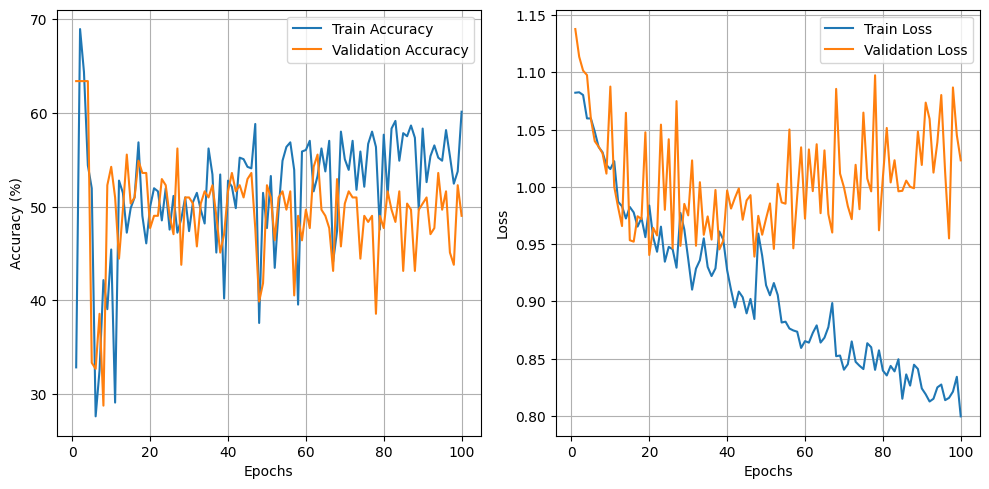

In [8]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), best_epoch_train_acc, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), best_epoch_val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), best_epoch_train_loss, label="Train Loss")
plt.plot(range(1, num_epochs + 1), best_epoch_val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig(f'./Graficas_entrenamiento/v2/representacion_1/longitud_28/CNN1D.png')
plt.show()

***Cargar el modelo :***

In [9]:
model.load_state_dict(torch.load("./Modelos/v2/representacion_1/longitud_28/CNN1D_fold_3.pth"))
model.to(device)
model.eval()

CNN1D(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=384, out_features=128, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)

***Evaluar el modelo :***

In [10]:
all_preds = []
all_labels = []

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [ ]:
print(train_df['Type'].unique())         # Ver las clases únicas
print(train_df['Type'].value_counts())   # Ver el conteo de cada clase

***Matriz de confusión :***

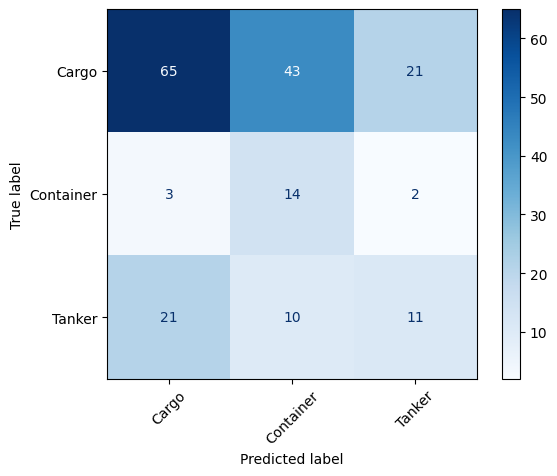

In [11]:
#class_names = ['AIS(30)','AIS(31-32)','AIS(36)','AIS(37)','AIS(52)','AIS(56-57)','AIS(60-69)','AIS(70-79)','AIS(80-89)','AIS(90-99)']
#class_names = ['Cargo', 'Fishing', 'Military', 'Sailing', 'Tanker']
class_names = ['Cargo', 'Container', 'Tanker']
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.show()

***Análisis de los resultados obtenidos :***

In [12]:
print(classification_report(all_labels, all_preds, target_names=class_names))

output_dir = Path('./Resultados/v2/representacion_1/longitud_28')

classification_text = classification_report(all_labels, all_preds, target_names=class_names)

with open(output_dir / 'CNN1D_report.txt', 'w') as f:
    f.write(classification_text)

              precision    recall  f1-score   support

       Cargo       0.73      0.50      0.60       129
   Container       0.21      0.74      0.33        19
      Tanker       0.32      0.26      0.29        42

    accuracy                           0.47       190
   macro avg       0.42      0.50      0.40       190
weighted avg       0.59      0.47      0.50       190

